<a href="https://colab.research.google.com/github/RX99999/TALIL-tagger/blob/main/Notebook_Etude_JDD_WISDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Etude du Jeu de Données WISDM**
Issu du papier **Activity Recognition using Cell Phone Accelerometers** - Kwapisz et al. (2010)

Disponible à : https://www.cis.fordham.edu/wisdm/dataset.php)

**Note : la véritable étude statistique commence partie 'Etude Statistique Generale'**

Mode d'emploi du Notebook :
1. Lecture des données 
- Exécuter les premières cellules de la section `Setup`, copier l'archive présente sur le drive (`archive.tar.gz`) dans `/content/drive/MyDrive` puis exécuter la dernière cellule.
- Les parties `Lectures des données nettoyées` jusqu'à `Cohérence temporelle` détaillent le nettoyage. Elles n'ont pas besoin d'être exécutées, sauf pour les quelques fonctions de la sous-partie `Fonctions utilitaires et constantes`.
- Exécuter la deuxième cellule de la partie `Données complètes nettoyées` pour récupérer le DataFrame complet des données nettoyées.
- Exécuter toutes les cellules des parties `Stratégies de création d'exemples d'apprentissage` et `Découpage par intervalles d'intersection nulle` afin de découper les données en exemples. Les deux DataFrames obtenus (50ms et 40ms) contiennent l'ensemble des données, et il est possible d'obtenir l'ensemble des points d'un exemple en filtrant sur la clé ("user", "activity", "sample_index", "example_index")
- Pour exporter les données en ARFF, il est possible d'exécuter les cellules correspondantes. Actuellement, les données ARFF sont disponibles sur le drive (fichier <...>). Il est possible de les lire et de récupérer les DataFrames correspondants (forme aplatie comme dans les fichier ARFF et forme complète comme dans le dataframe des données complètes) en copiant le fichier dans `/content/WISDM/WISM_ar_v1.1` et en exécutant la dernière cellule de la partie `Export au format ARFF`
2. Etude statistique / Apprentissage de classifieurs
- La partie <...>

## **Setup**
Récupère les données depuis le site, n'exécuter que si les données sont perdues entre deux lancements du notebook

In [ ]:
ROOT='/content/WISDM'
!WISDM_DIR='/content/WISDM/WISDM_ar_v1.1'
!WISDM_NAME='WISDM_ar_v1.1'
ROOT = '/content/WISDM'
WISDM_NAME = 'WISDM_ar_v1.1'
WISDM_DIR = f'{ROOT}/{WISDM_NAME}'

!echo $WISDM_NAME
!echo $WISDM_DIR

WISDM_ar_v1.1
/content/WISDM/WISDM_ar_v1.1


In [ ]:
!rm -rf $ROOT*
!mkdir $ROOT
!curl https://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz --output $ROOT/WISDM_ar_latest.tar.gz
!tar -xf /content/WISDM/WISDM_ar_latest.tar.gz -C $ROOT

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.8M  100 10.8M    0     0  9786k      0  0:00:01  0:00:01 --:--:-- 9786k


In [ ]:
!pip install fpdf
!pip install liac-arff
import arff
from fpdf import FPDF
import pandas as pd
from tqdm import tqdm
import numpy as np
import itertools as itl
from matplotlib import pyplot as plt
import sys
from google.colab import files
from google.colab import drive
from functools import reduce
from matplotlib.patches import Rectangle
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
import random as rd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40719 sha256=fe848aa91e8ae61a689d3dac01b42200200359aeb3eb11fd0598bffa247294c4
  Stored in directory: /root/.cache/pip/wheels/44/35/8b/86ce00cec7e4d13c5f189680ae0fa82f919bedc066c2cddae9
Successfully built fpdf
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11732 sha256=a5728d26cacc8ebaa2e1a49cef071664a8d6d2cf43d757207f5bc9a39ca4fd33
  Stored in directory: /root/.cache/pip/wheels/08/82/8b/5c514221984e88c059b94e36a71d4722e590acaae04deab22e
Successfully built liac-arff


In [ ]:
!mkdir -p /content/drive/MyDrive/Etude\ JDD

In [ ]:
!tar -xf /content/drive/MyDrive/*.tar.gz -C /content/drive/MyDrive/Etude\ JDD

tar: /content/drive/MyDrive/*.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


## **Lecture des données**

In [ ]:
num_data_points = 0
with open(f'{WISDM_DIR}/{WISDM_NAME}_raw.txt', 'r') as rawfile, open(f'{WISDM_DIR}/raw_clean.csv', 'w') as out:
    for line in rawfile.readlines():
        # Cleanup : some raw data points are missing Line Feeds, some have a trailing ','
        cleaned_lines = [x + '\n' if x[-1]  != ',' else x[:-1] + '\n' for x in line.strip('\n').split(';')[:-1]]
        out.writelines(cleaned_lines)
        num_data_points += len(cleaned_lines)

Sanity check : on vérifie ici que les données sont cohérentes. On remarque que l'on compte *1.098.208* points, soit un de plus que les *1.098.207* annoncés. **Je ne sais pas à quoi cela est dû, il faudra creuser**.

In [ ]:
print(f'raw data points : {num_data_points}\n')
!echo -e "lines in file : $(wc -l < $WISDM_DIR/raw_clean.csv)\n"
!echo -e "head of file : \n$(head $WISDM_DIR/raw_clean.csv)\n"
!echo -e "tail of file : \n$(tail $WISDM_DIR/raw_clean.csv)\n"

raw data points : 1098208

lines in file : 1098208

head of file : 
33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
33,Jogging,49106062271000,5.012288,11.264028,0.95342433
33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
33,Jogging,49106332290000,-1.1849703,12.108489,7.205164
33,Jogging,49106442306000,1.3756552,-2.4925237,-6.510526
33,Jogging,49106542312000,-0.61291564,10.56939,5.706926
33,Jogging,49106652389000,-0.50395286,13.947236,7.0553403
33,Jogging,49106762313000,-8.430995,11.413852,5.134871
33,Jogging,49106872299000,0.95342433,1.3756552,1.6480621

tail of file : 
19,Sitting,131623091524000,8.54,-1.31,2.49
19,Sitting,131623131471000,8.66,-1.31,2.37
19,Sitting,131623172578000,8.85,-1.27,2.18
19,Sitting,131623251466000,9.11,-1.38,1.95
19,Sitting,131623291475000,9,-1.5,1.8
19,Sitting,131623331483000,9,-1.57,1.69
19,Sitting,131623371431000,9.04,-1.46,1.73
19,Sitting,131623411592000,9.08,-1.38,1.69
19,Sitting,

### **Lecture des données nettoyées dans un DataFrame**

In [ ]:
raw_ts_data = pd.read_csv(f'{WISDM_DIR}/raw_clean.csv', sep=",", header=None)
raw_ts_data = raw_ts_data.rename(columns={0: "user", 1: "activity", 2: "timestamp", 3: "x-accel", 4: "y-accel", 5: "z-accel"})

In [ ]:
print(f'dataset size : {raw_ts_data.size}, datapoints : {len(raw_ts_data)}')
raw_ts_data.head(10)

dataset size : 6589248, datapoints : 1098208


user activity       timestamp   x-accel    y-accel   z-accel
0    33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1    33  Jogging  49106062271000  5.012288  11.264028  0.953424
2    33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3    33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4    33  Jogging  49106332290000 -1.184970  12.108489  7.205164
5    33  Jogging  49106442306000  1.375655  -2.492524 -6.510526
6    33  Jogging  49106542312000 -0.612916  10.569390  5.706926
7    33  Jogging  49106652389000 -0.503953  13.947236  7.055340
8    33  Jogging  49106762313000 -8.430995  11.413852  5.134871
9    33  Jogging  49106872299000  0.953424   1.375655  1.648062

### **Structure des données**

In [ ]:
!cat "$WISDM_DIR/$WISDM_NAME"_raw_about.txt

raw_about.txt for WISDM_Act_v1.1 dataset

See readme.txt for information about the WISDM Lab, rights,
and other general information.

Associated tasks: classification
Number of examples: 1,098,207
Number of attributes: 6
Missing attribute values: None
Class distribution: {
	Walking -> 424,400 -> 38.6%,
	Jogging -> 342,177 -> 31.2%,
	Upstairs -> 122,869 -> 11.2%,
	Downstairs -> 100,427 -> 9.1%,
	Sitting -> 59,939 -> 5.5%,
	Standing -> 48,395 -> 4.4% }

raw.txt follows this format:
[user],[activity],[timestamp],[x-acceleration],[y-accel],[z-accel];

This line is a representative example:
33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;

Sampling rate: 
20Hz (1 sample every 50ms)

Fields:
*user
	nominal, 1..36

*activity
	nominal, {
		Walking
		Jogging
		Sitting
		Standing
		Upstairs
		Downstairs }

*timestamp
	numeric, generally the phone's uptime in nanoseconds
		(In future datasets this will be miliseconds
		since unix epoch.)

*x-acceleration
	numeric, floating-point values 

Les données sont organisées en prises de données continues, une par **sample** pour chaque **activity**. Il existe plusieurs **sample** par **user** (voir plus loin). Certains users n'ont pas de données pour certaines activity.  


### **Fonctions utilitaires et constantes** 

In [ ]:
all_activities = ["Jogging", "Walking", "Sitting", "Standing", "Upstairs", "Downstairs"]

In [ ]:
by_sample = raw_ts_data.groupby(["user", "activity"])

In [ ]:
by_class = raw_ts_data.groupby(["activity"])

In [ ]:
def sub_df(data_df, user=None, activity=None, sample_index=None):
    """
      returns a sub-dataframe containing the selected user and activity lines. 
      => SELECT * FROM data_df WHERE user=... AND activity=... (AND sample_index=...)
      Optional parameter "sample_index" can be used to select a specific sample (see further)

      The result is a mutable copy of the original dataframe (one cannot change the original dataframe through it)
    """
    if user is None and activity is None:
        return data_df 
    elif user is None:
        return data_df[data_df["activity"] == activity]
    elif activity is None:
        return data_df[data_df["user"] == user]
    elif sample_index is None:
        return data_df[
            (data_df["user"] == user) & (data_df["activity"] == activity)]
    else:
        return data_df[
            (data_df["user"] == user) & (data_df["activity"] == activity) &
            (data_df["sample_index"] == sample_index)]


In [ ]:
def interv(data_df, min_val=None, max_val=None, keep = (False, False)):
    """
      returns a selector corresponding to the specified interval 
      (parameter keep allows open and closed intervals on both sides).
      The selector can then be used in conjunction with other selectors like df[...] == ...

      e.g : data[interv(data, 10 ** 9, 2 * 10 ** 9) & (data["x-accel"] == 0)]
    """
    if min_val is None and max_val is None:
        return [True] * len(data_df)
    elif min_val is None:
        lt = data_df["timestamp"] <= max_val if keep[1] else data_df["timestamp"] < max_val
        return lt
    elif max_val is None:
        gt = data_df["timestamp"] >= min_val if keep[0] else data_df["timestamp"] > min_val
        return gt
    else:
        gt = data_df["timestamp"] >= min_val if keep[0] else data_df["timestamp"] > min_val
        lt = data_df["timestamp"] <= max_val if keep[0] else data_df["timestamp"] < max_val
        return (lt) & (gt)

In [ ]:
# This is defined later (part IV)
EXAMPLE_DURATION = 10 * 10 ** 9 # E.D. = 10s in milliseconds

### **Nettoyage et découpage des séries**

Après nettoyage du fichier csv, quelques étapes restent à effectuer afin d'obtenir des séries exploitables :
- Elimination des points aberrants
- Detection des prises de vue (*sample*) et découpage
- Vérification de la cohérence temporelle

#### **1. Points aberrants**  

Certaines lignes ne sont constituées que de zéros pour chaque variable. Ces points ne correspondent visiblement pas à des valeurs réelles (un timestamp nul par exemple ne correspond à rien).  
Il nous faut donc éliminer ces points.

In [ ]:
!echo "lines containing zeros : $(grep -P '([^,],)*,0,.*' $WISDM_DIR/raw_clean.csv | wc -l)"
!echo "lines containing a zero timestamp : $(grep -P '^[^,]*,[^,]*,0,.*' $WISDM_DIR/raw_clean.csv | wc -l)"
!echo "first 3 lines containing a zero timestamp :"
!grep -P '^[^,]*,[^,]*,0,.*' $WISDM_DIR/raw_clean.csv | head -n 3

lines containing zeros : 17596
lines containing a zero timestamp : 12845
first 3 lines containing a zero timestamp :
20,Walking,0,0,0,0.0
20,Walking,0,0,0,0.0
20,Walking,0,0,0,0.0


Il est malheureusement impossible de savoir d'où viennent ces valeurs aberrantes. On peut cependant **analyser la proportion de valeurs aberrantes** pour chaque couple *(user, activity)*.  
Ces connaissances peuvent nous servir plus tard lors de l'analyse des données (pour expliquer des comportements aberrants par exemple)

In [ ]:
list_0s = []
for (i, u, a) in tqdm(raw_ts_data[raw_ts_data["timestamp"] == 0][["user", "activity"]].drop_duplicates().itertuples()):
    spec_sub_df = sub_df(raw_ts_data, u, a)
    len_0s = len(spec_sub_df[spec_sub_df["timestamp"] == 0])
    list_0s.append((u, a, len(spec_sub_df), len_0s, 100 * len_0s / len(spec_sub_df)))

39it [00:03, 12.71it/s]


In [ ]:
print("\nRatio of unexploitable (timestamp = 0) values vs. total values")
first_sub_val = True
sub_val = 1
problematics = []
maybe_problematics = []
for (u, a, ltot, l0s, ratio) in sorted(list_0s, key=lambda x: x[4], reverse = True):
    if (ratio < sub_val and first_sub_val):
        print("-" * 21 + f"vvv Less than {sub_val} % vvv" + "-" * 21)
        first_sub_val = False
    elif ratio >= sub_val:
        problematics.append((u, a))
    maybe_problematics.append((u, a))
    print(f'entry \t{u}, {a} \t:   {l0s} / {ltot}    \t=   {ratio:.3f} %')


Ratio of unexploitable (timestamp = 0) values vs. total values
entry 	20, Jogging 	:   2220 / 12948    	=   17.146 %
entry 	32, Jogging 	:   1996 / 12245    	=   16.301 %
entry 	15, Jogging 	:   2001 / 12800    	=   15.633 %
entry 	29, Jogging 	:   1330 / 12788    	=   10.400 %
entry 	27, Jogging 	:   1183 / 12039    	=   9.826 %
entry 	18, Jogging 	:   1082 / 11993    	=   9.022 %
entry 	13, Jogging 	:   1028 / 12329    	=   8.338 %
entry 	6, Jogging 	:   857 / 11818    	=   7.252 %
entry 	27, Upstairs 	:   191 / 3255    	=   5.868 %
entry 	32, Downstairs 	:   135 / 2343    	=   5.762 %
entry 	29, Downstairs 	:   64 / 4329    	=   1.478 %
entry 	36, Jogging 	:   151 / 12038    	=   1.254 %
entry 	6, Walking 	:   137 / 12399    	=   1.105 %
---------------------vvv Less than 1 % vvv---------------------
entry 	27, Walking 	:   110 / 12476    	=   0.882 %
entry 	20, Walking 	:   107 / 13134    	=   0.815 %
entry 	18, Upstairs 	:   16 / 2425    	=   0.660 %
entry 	15, Walking 	:   62 / 

On observe que 13 couples ont plus de 1 % de valeurs aberrantes. 3 en particulier dépassent 15 % et 10 dépassent 5 %. Le reste est en dessous de 1 %.   On considère donc que les 13 premiers couples sont potentiellement dangereux (enregistrés dans la liste `problematics`)

Pour la suite de l'étude, **nous n'utiliseront que les données non-aberrantes** :

In [ ]:
without_zeros = raw_ts_data[~(raw_ts_data["timestamp"] == 0)].copy()
print(f'total size : {len(raw_ts_data)}, cleaned size : {len(without_zeros)}' 
      f', number of removed lines : {len(raw_ts_data) - len(without_zeros)}')

total size : 1098208, cleaned size : 1085363, number of removed lines : 12845




#### **2. Detection de prise de vue**  

Afin d'avoir des données exploitables, il nous faut pouvoir identifier les prises de vues continues (*sample*) au sein du dataframe de données. Cependant, pour un couple `(user, activity)` - *entry* - donné, plusieurs prises de vue peuvent êtres rassemblées sans distinction.  

Afin d'avoir des données exploitables, il nous faut donc automatiquement séparer les différents *samples* de chaque *entry*. L'objectif est de rajouter une colonne `sample_index`, telle que `(user, sample_index, activity)` soit une clé unique représentant une seule prise de vue si elle existe.  

Pour se faire, il nous faut détecter les "trous" - *gap* - dans les différentes *entry*. L'algorithme est détaillé plus bas:

In [ ]:
def find_gaps(ts, acceptable_error, n=10, dx=1):
    """
      detects gaps (large differences in timestamp) and returns the corresponding timestamps.
      A gap is defined by a difference in timestamps which is significantly greater than is neigbours.

      The decision rule is as follows : for the n biggest timestamp differences, if one is different than its
      neighbours (ts differences located +- dx away in the series) by more than acceptable_error,
      then it is a gap.
    """
  
    def make_gap(deltas, index):
        """
          creates a timestamp tuple (gap) from a gap index (where the gap frontier is located in the series)
        """
        gap_begin = ts["timestamp"][index]
        gap_end = ts["timestamp"][deltas.index[deltas.index.get_loc(index)-1]]
        if (gap_begin > gap_end):
            gap_begin, gap_end = gap_end, gap_begin
        return (gap_begin, gap_end)

    def get_neighbouring_diffs(deltas, limits, index, delta):
        """
          returns the neighbouring differences of a gap candidate
        """
        # neighbours
        prev_index = deltas.index[deltas.index.get_loc(index) - dx] if index >= deltas_lims[0] else index
        next_index = deltas.index[deltas.index.get_loc(index) + dx] if index < deltas_lims[1] else index

        # differences between the gap candidate and its neighbours
        diff_prev = abs(deltas[prev_index] - delta)
        diff_next = abs(deltas[next_index] - delta)

        return (diff_prev, diff_next)
    
    # preparation : we order the dataframe by timestamp 
    # (in case a early sample is located after a late sample in the dataframe)
    ordered_timestamps = ts["timestamp"].sort_values()
    shift_none = ordered_timestamps[1:len(ordered_timestamps) - 1]
    shift_once = ordered_timestamps.shift(1)[1:len(ordered_timestamps) - 1]

    # and compute the timestamp differences for each timestamp, as well as find the n largest values
    deltas = shift_none - shift_once
    max_deltas = deltas.nlargest(n, "all")
    deltas_lims = (dx, len(deltas.index) - dx)

    # algorithm : the aformentioned decision rule
    gaps = []
    for (index, delta) in max_deltas.items():
        # neigbouring differences
        diff_prev, diff_next = get_neighbouring_diffs(deltas, deltas_lims, index, delta)

        # the candidate is at a gap frontier if the differences are bigger than acceptable_error
        if diff_prev > acceptable_error or diff_next > acceptable_error :
            gaps.append(make_gap(deltas, index))

    return sorted(gaps, key = lambda g: g[0])

In [ ]:
def sub_seriesify(raw_data, user, activity, gaps):
    """
      computes the samples of a (user, activity) entry using the given gaps.
      The input dataframe is mutated, such that the "sample_index" column reflects
      the correct sample for the given (user, activity) entry. Hence, sub_seriesify should be used in a loop,
      mutating the dataframe for each entry.
    """
    next_start = 0
    sample_index = 0

    # for each gap (the sys.maxsize is used to compute the last sample, which is located after the last gap)
    for gap_begin, gap_end in gaps + [(sys.maxsize, None)]:
        # the sub-series located between the last gap's end and the current gap's beginning is the next sample 
        raw_data.loc[
            (raw_data["user"] == user) & (raw_data["activity"] == activity) &
            (interv(raw_data, next_start, gap_begin, keep = (True, True))), 
            "sample_index"] = sample_index
        
        sample_index = 1 + sample_index
        next_start = gap_end
    
    return raw_data


In [ ]:
def make_sampled(base_data, acceptable_error, n=10, dx=1, return_gaps=False):
    """
      generates a sampled version of a raw dataframe using the parameters acceptable_error, n and dx

      if return_gaps is True then all gaps are saved and returned as well
    """
    sampled_data = base_data.copy()
    gaps = dict(map(lambda x: (x,{}), all_activities))
    for user, activity in tqdm(itl.product(range(1, 37), all_activities), total=216):
        try:
            entry_gaps = find_gaps(sub_df(base_data, user, activity), acceptable_error, n=n, dx=dx)
            gaps[activity][user] = entry_gaps
        except IndexError as e:
            print(f'ERROR {e} FOR {user, activity}')
        sampled_data = sub_seriesify(sampled_data, user, activity, entry_gaps)
    
    return sampled_data if not return_gaps else (sampled_data, gaps)

Les fonctions suivantes permettent de dessiner les *gaps*, ainsi que de représenter les séries en fonction de leur *sample_index*, à des fins de debugging.

In [ ]:
def display_gap_cutoffs(specific_series, gaps, axis, title):
    """
      displays a given (user, activity) entry, as well as vertical lines for each gap frontier
    """
    axis.title.set_text(title)

    axis.plot(specific_series["timestamp"], specific_series["x-accel"])
    for gap in gaps:
        axis.axvline(x = gap[0], color = 'red')
        axis.axvline(x = gap[1], color = 'red')

In [ ]:
def display_gaps(subd_specific_series, gaps, axis, title):
    """
      displays a given (user, activity) entry as a scatter plot, 
      coloring each sample differently, as well as vertical lines for each gap frontier
    """
    axis.title.set_text(title)
    
    categories = np.unique(subd_specific_series["sample_index"])
    colors = np.linspace(0, 1, len(categories))
    colordict = dict(zip(categories, colors))  

    sample_colors = subd_specific_series["sample_index"].apply(lambda x: colordict[x])

    axis.scatter(subd_specific_series["timestamp"], subd_specific_series["x-accel"], c=sample_colors, s=0.5)

    for gap in gaps:
        axis.axvline(x = gap[0], color = 'red')
        axis.axvline(x = gap[1], color = 'red')

In [ ]:
def display_gaps_for_activity(activity, raw_data, acceptable_error=None, all_gaps=None, disp_range=False):
    """
      displays gaps / gap frontiers (depending on the value of disp_range) 
      for an entire activity, as one page
    """
    assert acceptable_error is not None or all_gaps is not None, "/!\ please specify a gap finding method"

    f, ax = plt.subplots(12, 3)
    f.set_figwidth(18)
    f.set_figheight(30)
    plt.subplots_adjust(
        left=0.1, bottom=0.1, right=0.9, top=0.9,
        wspace=0.1, hspace=0.5)

    for user in tqdm(range(1, 37)):
        specific_series = sub_df(raw_data, user, activity)
        gaps = find_gaps(specific_series, acceptable_error) if all_gaps is None else all_gaps[user]

        axis = ax[(user - 1) % 12, int((user - 1) / 12)]
        if disp_range:
            display_gaps(specific_series, gaps, axis, f'Raw ({user}, {activity})')
        else:
            display_gap_cutoffs(specific_series, gaps, axis, f'Raw ({user}, {activity})')

Ici par exemple, le découpage effectué pour les classe "Upstairs" et "Walking".  
*Les cases vides correspondent à des entrées sans données. On peut remarquer quelques découpages débattables, car les constantes n, dx et acceptable_error sont choisies arbitrairement.*  
L'analyse des résultats va nous permettre de trouver les bonnes valeurs de `n`, `dx` et `acceptable_error`, ainsi que de trouver des parties potentiellement problématiques dans les données (analyse visuelle)

100%|██████████| 36/36 [00:05<00:00,  7.19it/s]


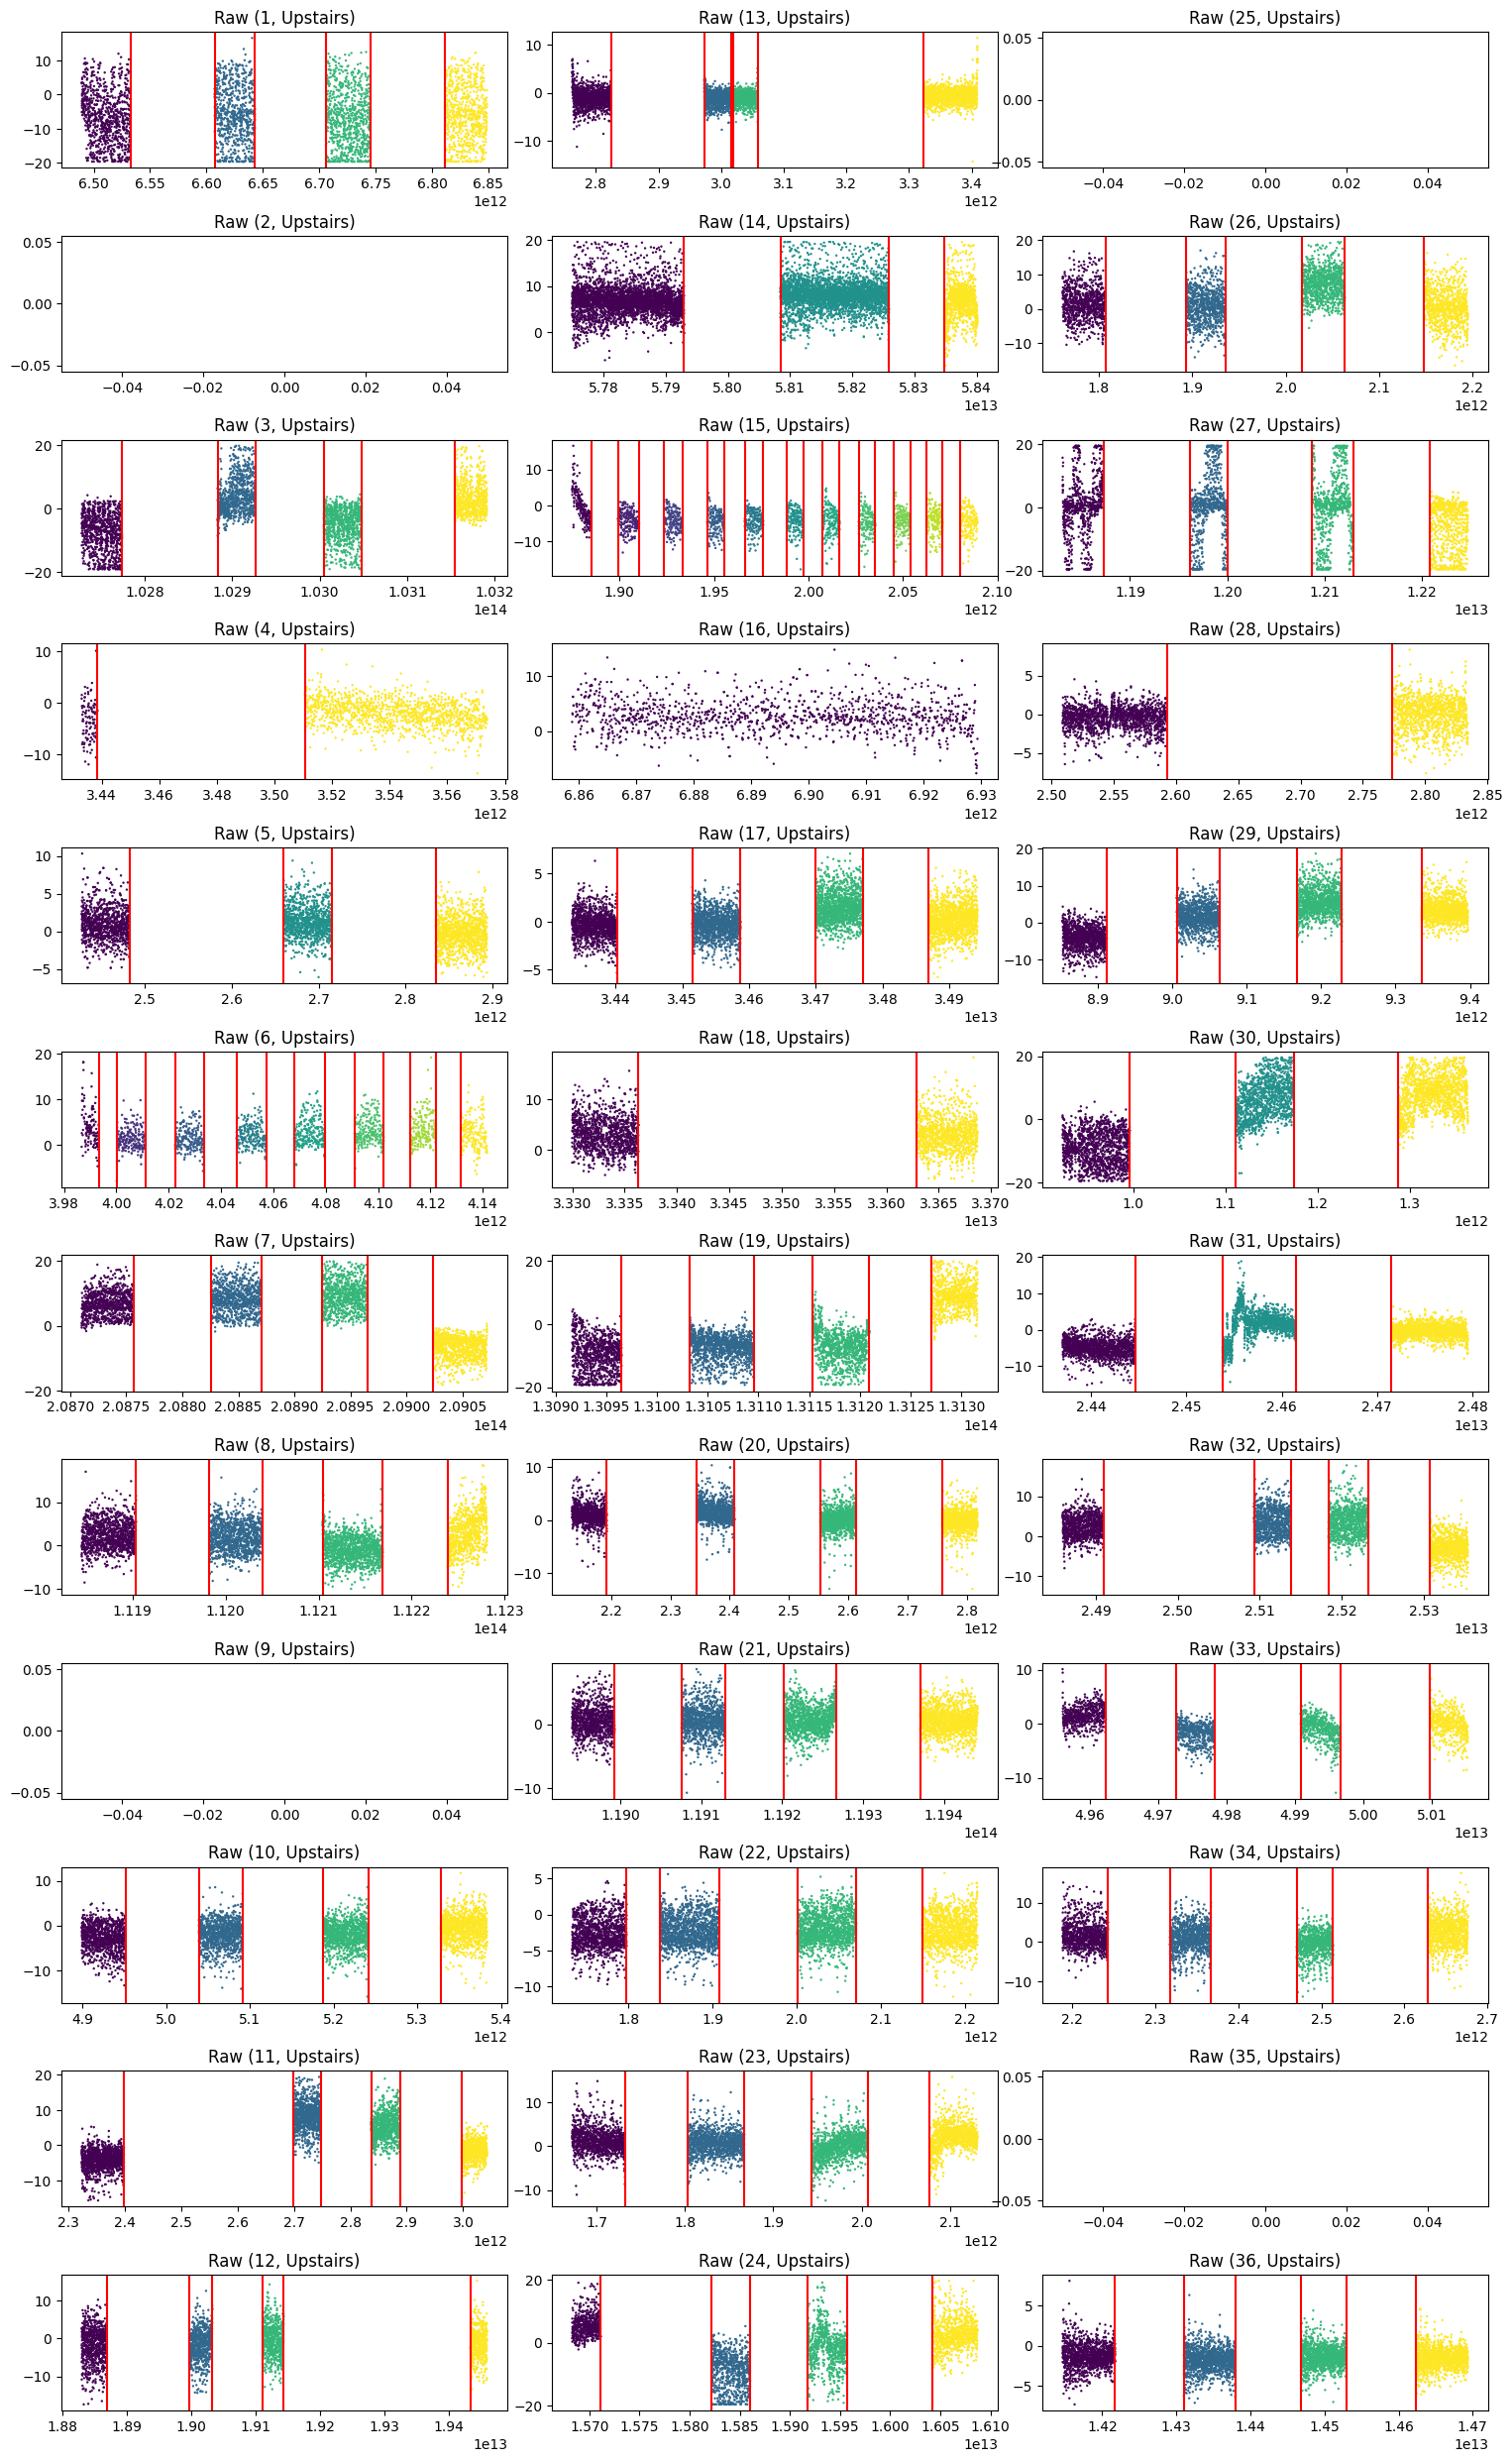

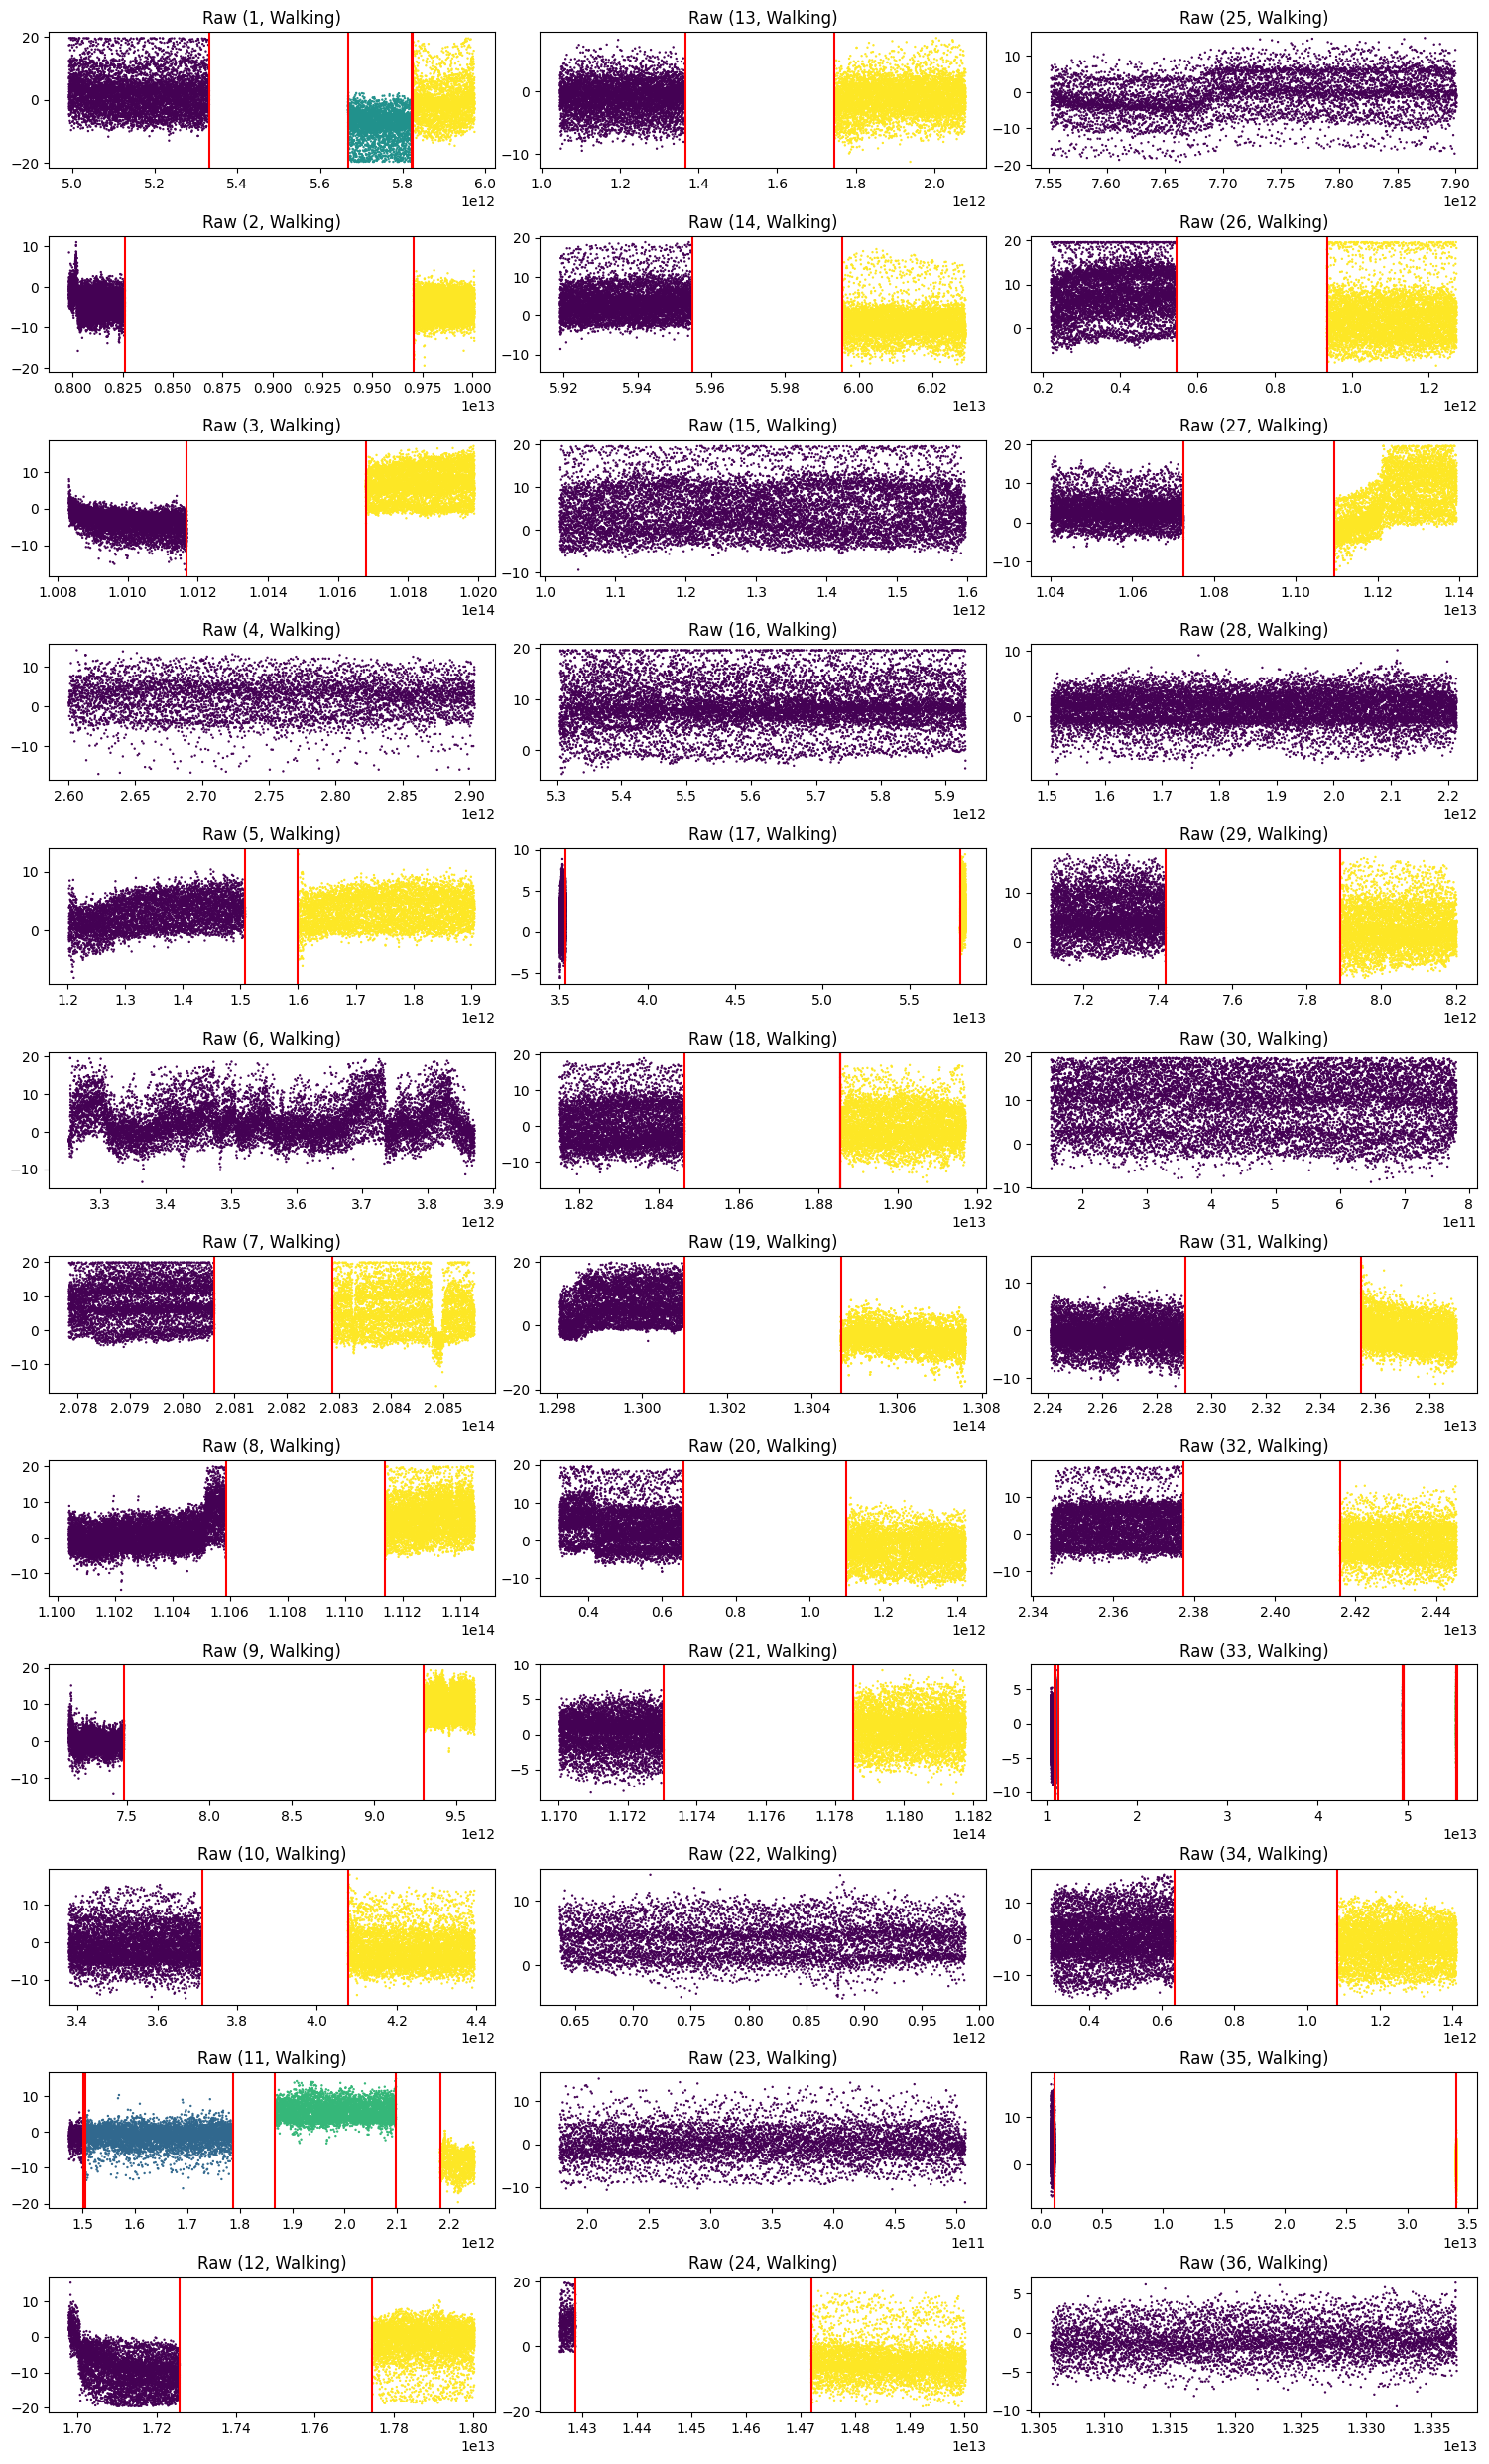

In [ ]:
sampled_without_zeros_test, gaps_without_zeros_test = make_sampled(without_zeros, 10 ** 9, n=10, dx=1, return_gaps=True)
display_gaps_for_activity("Upstairs", sampled_without_zeros_test, all_gaps=gaps_without_zeros_test["Upstairs"], disp_range = True), 
display_gaps_for_activity("Walking", sampled_without_zeros_test, all_gaps=gaps_without_zeros_test["Walking"], disp_range = True)

En jouant avec les constantes, et en examinant les séries pour lesquelles le doute est permis (ci-dessous un élément de code modulable, utilisé pour examiner les séries), **nous pouvons tirer les conséquences suivantes** :  

- Beaucoup d'*entries* présentent des petits trous (~0 à 5s), qui lors du découpement créent des samples très courts (quelques secondes seulement).  
Un *acceptable_error* de 0.5s (0.5E9 ns) me semble tout de même pertinent pour obtenir séries cohérentes (La fréquence d'échantillonage est d'environ 50ms, on autorise donc un *sample* à présenter des trous de 10 points au maximum). Il sera cependant nécessaire d'ignorer entièrement les samples trop courts.  

- D'autres *entries* possèdent très peu de données au total. De même, il sera nécessaire d'ignorer les samples générés s'ils sont trop courts.  

- Le paramètre `dx` ne semble pas avoir une grande importance, il peut être laissé à 1 ou 2 pour avoir des résultats cohérents. Le paramètre `n` doit être assez élevé si on ne veut pas oublier des *gaps*, une valeur entre 10 et 20 est cohérente.

- Certaines séries présentent des *'saccades'* - des ruptures brusques de la moyenne de mesure (le temps reste continu).  
Je suppose que ces saccades font partie de la structure des données (peut-être dû à une rotation des capteurs par exemple), elles sont donc conservées. *Leur détection serait d'ailleurs presque impossible automatiquement*    

- Certaines séries présentent de la saturation au niveau des mesures. Il est impossible d'ajuster pour cet effet (dû à la mesure), qui sera également considéré comme partie intégrante de la structure des données.  

- Les `user` annoncés dans l'article (29) ne correspondent pas aux 36 effectivement présents dans les données. Il est donc impossible de comparer le nombre de séries obtenues.  
On remarquera cependant que le nombre d'*entries* manquante pour chaque `activity` correspond au nombre d'`user` manquant dans les graphiques d'analyse construits (on peut donc se rassurer sur l'exactitude des résultats produits).








In [ ]:
points_per_user = raw_ts_data["user"].drop_duplicates()
gb_user = raw_ts_data.groupby(["user"])

print("missing entries : ", end="")
for activity in all_activities:
    print(f'{activity}={36 - len(raw_ts_data[["user", "activity"]][raw_ts_data["activity"] == activity].groupby(["user"]))}', end=" ")
print()


missing entries : Jogging=4 Walking=0 Sitting=13 Standing=12 Upstairs=4 Downstairs=4 


gap lengths :  ['3.7112E+11']


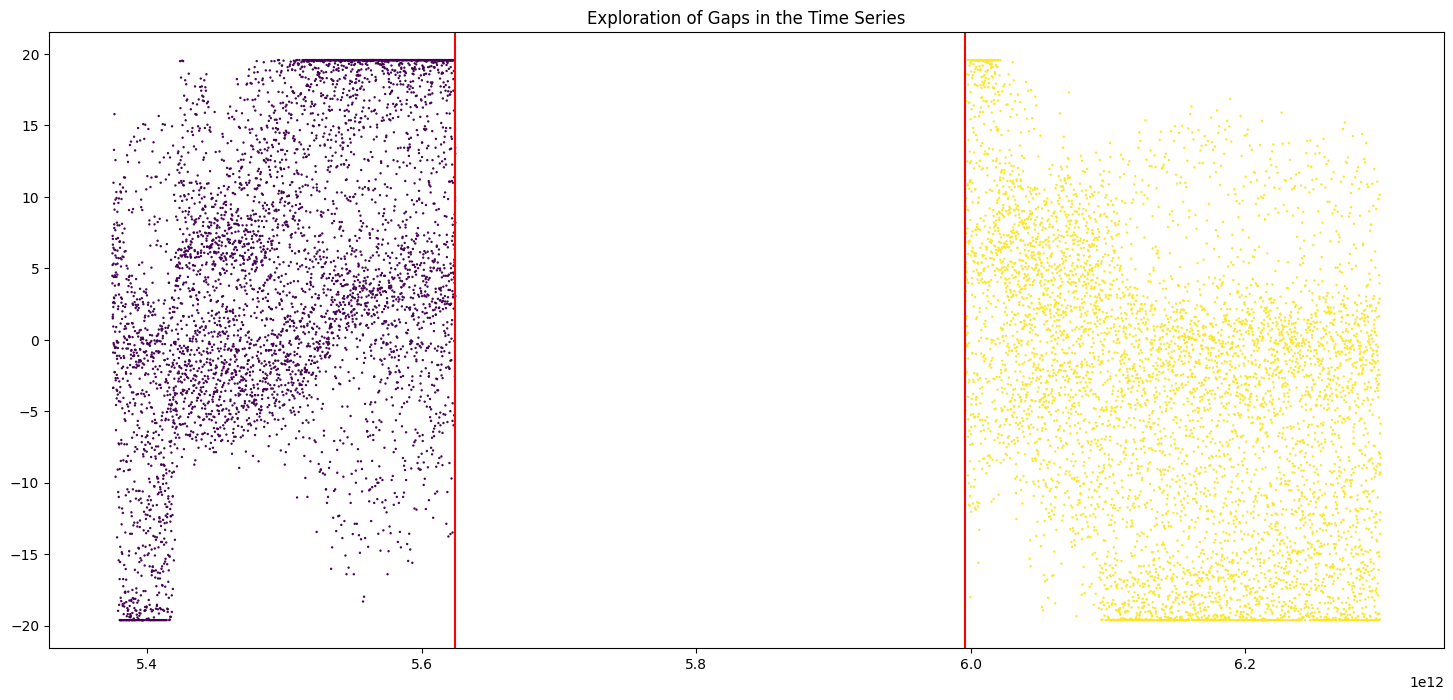

In [ ]:
f, axis = plt.subplots(1, 1)
f.set_figwidth(18)
f.set_figheight(8)

#plt.xlim([2.0744 * 10 ** 14, 2.0746 * 10 ** 14])
specific_user, specific_activity = (1, "Jogging")

specific_test_series = sub_df(without_zeros, specific_user, specific_activity)
specific_gaps = find_gaps(specific_test_series, 10 ** 9, n=20, dx=2)
sampled_specific_series = sub_seriesify(specific_test_series.copy(), specific_user, specific_activity, specific_gaps)

print('gap lengths : ', list(map(lambda x: f'{x[1] - x[0]:.4E}', specific_gaps)))

display_gaps(
    sampled_specific_series, specific_gaps, 
    axis, "Exploration of Gaps in the Time Series")


Les cellules ci-dessous permettent de générer un pdf récapitulant l'ensemble des découpages en *sample* pour des paramètres `acceptable_error`, `n` et `dx` choisis. **L'exécution est très lente, ne pas lancer sauf si nécessaire**.

In [ ]:
%%capture
!mkdir /content/figures
sampled_benchmark, gaps_benchmark = make_sampled(without_zeros, 5 * 10 ** 8, n=20, dx=1, return_gaps=True)
for activity in tqdm(all_activities):
    display_gaps_for_activity(
        activity, sampled_benchmark, 
        all_gaps=gaps_benchmark[activity], 
        disp_range=True)
    
    plt.savefig(f'/content/figures/{activity}.png')

In [ ]:
pdf = FPDF()
for image in tqdm(map(lambda x: f'/content/figures/{x}.png', all_activities)):
    pdf.add_page()
    pdf.image(image, 5, -5, 200, 300)
_ = pdf.output("/content/figures/all_activities_5-8_20_1.pdf", "F")

6it [01:41, 16.96s/it]


In [ ]:
ACCEPTABLE_TIMESTAMP_ERROR = 5 * 10 ** 8

In [ ]:
sampled_without_zeros, gaps_without_zeros = make_sampled(without_zeros, ACCEPTABLE_TIMESTAMP_ERROR, n=20, dx=2, return_gaps=True)

100%|██████████| 216/216 [01:07<00:00,  3.18it/s]


In [ ]:
max_num_samples = max(map(lambda x: max(map(len, x.values())), gaps_without_zeros.values()))

In [ ]:
print(max_num_samples)

4


#### **3. Coherence temporelle**  

Certains classifieurs nécessitent des entrées de dimension (nombre de points) fixée. Il est donc nécessaire d'analyser les différences entre deux *timestamp* consécutifs au sein des séries pour déterminer si elles sont cohérentes.  

Les deux fonctions suivantes permettent d'analyser les *timestamp deltas* d'un sample, c'est à dire les différences entre deux timestamp consécutifs.

In [ ]:
def analyse_deltas(specific_sample, user, activity, sample_index, axis, err=None):
    """
      displays useful information about timestamp deltas in a specific series:
      - complte histogram of the deltas (should be centered around 5ms)
      - stats (average, std deviation, min, max)
      - number of non-conform deltas (more than +- err away from the average)
      - number of zeros (duplicates)
      - how far the max is in averages (how many 5ms steps does it take to reach the max)
      - color based on whether the sample is part of the known problematic sets (the ones with missing values)
    """
    # 1. find the deltas (same algorithm as find_gaps)
    ordered_timestamps = specific_sample["timestamp"].sort_values()
    shift_none = ordered_timestamps[1:len(ordered_timestamps) - 1]
    shift_once = ordered_timestamps.shift(1)[1:len(ordered_timestamps) - 1]
    deltas = shift_none - shift_once

    # 2. analysis:
    axis.hist(deltas, bins=100)#range(0, 3 * 10 ** 8, 10 ** 6))
    axis.set_facecolor(
        (1.0, 0.7, 0.7) if (user, activity) in problematics else (
        (1.0, 1.0, 0.7) if (user, activity) in maybe_problematics else 
        (0.7, 0.7, 1.0) ))

    avg = deltas.mean() # average delta
    std = np.std(deltas) # std deviation of deltas
    r_err = err if err is not None else std
    nc = len(deltas[(deltas < avg - r_err) | (deltas > avg + r_err)]) # amount of non-conform deltas
    ld = len(deltas) # amount of deltas
    mn = deltas.min() # min delta
    mx = deltas.max() # max delta
    n0s = len(deltas[deltas == 0.0]) # amount of zero-deltas
    axis.set_title(
        f'({user}, {activity}, {sample_index}) : avg={avg:.4E}, '
        f'std={std:.4E}, \nnc({r_err:.0E}):'
        f'{nc}/{ld}={100 * nc/ld:.2f}%, n0s={n0s}\n'
        f'min={mn:.4E}, max={mx:.4E}({mx/avg:.2f}*avg)')

In [ ]:
def analyse_deltas_with_values(specific_sample, user, activity, sample_index, axis, interv=None):
    """
      displays useful information about timestamp deltas:
      - x values overlayed with deltas
      - the timestamp interval to be displayed can be fixed with interv
    """
    # 1. find the deltas (same algorithm as find_gaps)
    ordered_timestamps = specific_sample["timestamp"].sort_values()
    shift_none = ordered_timestamps[1:len(ordered_timestamps) - 1]
    shift_once = ordered_timestamps.shift(1)[1:len(ordered_timestamps) - 1]
    deltas = shift_none - shift_once

    # 2. analysis:
    axes = [axis, axis.twinx()]
    axes[-1].spines['right'].set_position(('axes', 1.05))
    axes[-1].set_frame_on(True)
    axes[-1].patch.set_visible(False)

    #axes[0].tick_params(axis='y', colors=color)

    if interv is not None:
        plt.xlim(interv)

    axes[0].plot(specific_sample["timestamp"], specific_sample["x-accel"])
    axes[1].plot(specific_sample["timestamp"][0:len(ordered_timestamps) - 2], deltas, c='r')
    axes[1].set_ylabel('deltas', c='r')

En analysant quelques séries, on peut observer plusieurs phénomènes:
- Les séries présentent des *deltas* nuls, indiquant que certains timestamps sont répétés au sein des données.
- Les séries sont effectivement centrées autour d'un *delta* de 50ms, mais elles comportent des pics à certains multiples de 50ms, indiquant sûrement des données manquantes *(On remarque cependant que cela n'a pas l'air corrélé avec les séries comportant des lignes nulles étudiées auparavant)*.
- Certaines séries semblent posséder énormément de *deltas* différents de 50ms, je ne sais pas expliquer ce phénomène. Nous verrons que ces séries posent problème. 

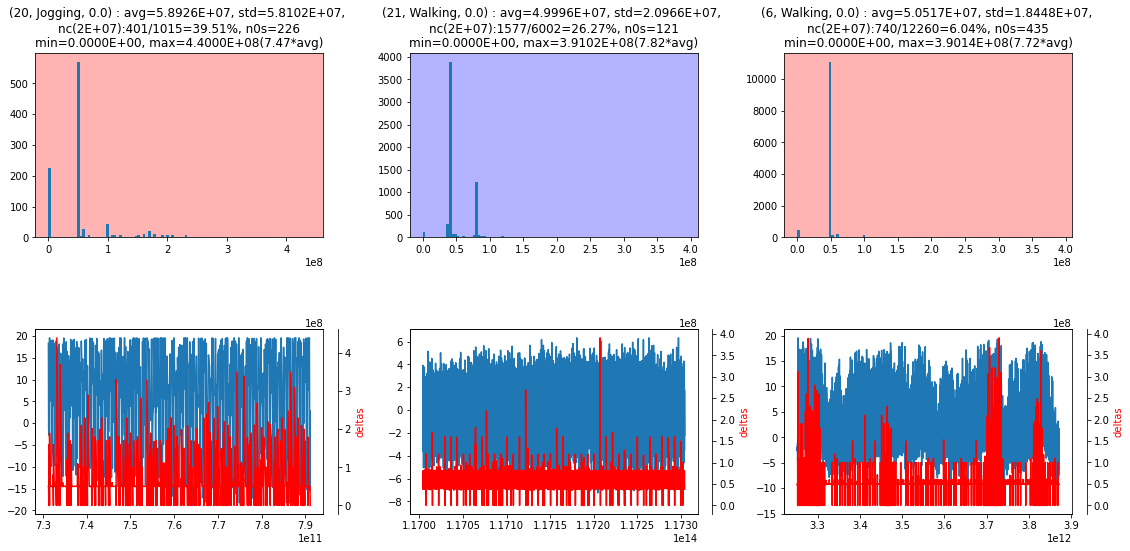

In [ ]:
f, axis = plt.subplots(2, 3)
f.set_figwidth(18)
f.set_figheight(8)
plt.subplots_adjust(
        left=0.1, bottom=0.1, right=0.9, top=0.9,
        wspace=0.3, hspace=0.5)

df_20_Jogging_base = sub_df(sampled_without_zeros, 20, "Jogging", 0.0)
df_21_Walking_base = sub_df(sampled_without_zeros, 21, "Walking", 0.0)
df_6_Walking_base = sub_df(sampled_without_zeros, 6, "Walking", 0.0)

analyse_deltas(df_20_Jogging_base, 20, "Jogging", 0.0, axis[0][0], err=2.5 * 10 ** 7)
analyse_deltas_with_values(df_20_Jogging_base, 20, "Jogging", 0.0, axis[1][0])
analyse_deltas(df_21_Walking_base, 21, "Walking", 0.0, axis[0][1], err=2.5 * 10 ** 7)
analyse_deltas_with_values(df_21_Walking_base, 21, "Walking", 0.0, axis[1][1])
analyse_deltas(df_6_Walking_base, 6, "Walking", 0.0, axis[0][2], err=2.5 * 10 ** 7)
analyse_deltas_with_values(df_6_Walking_base, 6, "Walking", 0.0, axis[1][2])

Il nous faut donc nettoyer les données afin d'avoir un seul timestamp environ toutes les 50ms.  

Une analyse plus poussée sur les *deltas* nuls permet de montrer que la plupart correpondent à des duplications de données. Dans certains cas très rares, deux données différentes contiennent le même timestamp, mais ces cas ne sont pas significatifs (quelques cas pour des séries de plusieurs milliers de points).

In [ ]:
def get_duplicate_info(specific_sample, show_all=True, keep_singles=False):
    """
      gets relevant duplicate info for all timestamps of a given specific series.
      A 'duplicate' is any set of rows with the same timestamp (delta = 0 in the above analyses)
      This function returns a dataframe with unique timestamps as indices and lists as values.
      Each list contains the values corresponding to a column for the given timestamp, coupled with its frequency
    """
    def combine_duplicates(ls):
        """
          combines a list of values into a duplicate list (unique values coupled with their frequency).
          If keep_singles is True, all lists are returned
          If keep_singles is False, lists containing only one value (non-duplicates) are removed
          If show_all is False, duplicates where all values (x, y and z) remain equal are also removed 
        """
        vals = np.unique(ls)
        if not keep_singles and (len(ls) if show_all else len(vals)) == 1:
            return None
        counts = list(map(lambda x: (x, ls.count(x)), vals))
        return sorted(counts, key=lambda x: x[1], reverse=True)

    analyse_zero_deltas = specific_sample.groupby(["timestamp"])

    lists_duplicates_x = analyse_zero_deltas["x-accel"].apply(list).map(combine_duplicates)
    lists_duplicates_y = analyse_zero_deltas["y-accel"].apply(list).map(combine_duplicates)
    lists_duplicates_z = analyse_zero_deltas["z-accel"].apply(list).map(combine_duplicates)

    lists_duplicates = pd.DataFrame(lists_duplicates_x)
    lists_duplicates["y-accel"] = lists_duplicates_y
    lists_duplicates["z-accel"] = lists_duplicates_z

    cond = ~(lists_duplicates["x-accel"].isna() & lists_duplicates["y-accel"].isna() & lists_duplicates["z-accel"].isna())
    return lists_duplicates[cond]

In [ ]:
dup_dup_info_21_Walking = get_duplicate_info(df_21_Walking_base, show_all=True, keep_singles=False)
dif_dup_info_21_Walking = get_duplicate_info(df_21_Walking_base, show_all=False, keep_singles=False)

print(f'sample size : {len(df_21_Walking_base)}')
print(f'duplicated timestamps : {len(dup_dup_info_21_Walking)}')
print(f'duplicated timestamps with distinct data : {len(dif_dup_info_21_Walking)}')

dif_dup_info_21_Walking

sample size : 6004
duplicated timestamps : 82
duplicated timestamps with distinct data : 3


x-accel                  y-accel  \
timestamp                                                          
117084643073000                    None  [(5.83, 1), (17.16, 1)]   
117100661383000  [(2.26, 2), (3.06, 1)]  [(9.96, 2), (10.27, 1)]   
117235791388000                    None                     None   

                                  z-accel  
timestamp                                  
117084643073000    [(1.46, 1), (1.61, 1)]  
117100661383000    [(2.07, 2), (1.88, 1)]  
117235791388000  [(-3.49, 2), (-0.93, 1)]

Un nettoyage des données dupliquées peut donc être effectué, en choisissant une des valeurs disponibles (celle aparaissant le plus) pour chaque timestamp dupliqué

In [ ]:
def remove_duplicates(specific_sample):
    """
      removes duplicates (as defined above) from a specific series, by choosing one (the most numerous)
      value within duplicate lists
    """
    var_specific_sample = specific_sample.copy()

    duplicate_info = get_duplicate_info(specific_sample, show_all=True, keep_singles=True)
    # we want to keep the most numerous value in each duplicate, i.e. the first one in the sorted duplicate list
    target_x = duplicate_info["x-accel"].map(lambda x: x[0][0])
    target_y = duplicate_info["y-accel"].map(lambda x: x[0][0])
    target_z = duplicate_info["z-accel"].map(lambda x: x[0][0])

    var_specific_sample["x-accel"] = specific_sample["timestamp"].map(lambda t: target_x[t])
    var_specific_sample["y-accel"] = specific_sample["timestamp"].map(lambda t: target_y[t])
    var_specific_sample["z-accel"] = specific_sample["timestamp"].map(lambda t: target_z[t])

    return var_specific_sample.drop_duplicates()

Pour ce qui est des *deltas* > 50ms, il nous faut construire des données interpolées pour combler les trous, afin d'obtenir des dataframes dont les *deltas* sont le plus proche possible de 50ms (points répartis uniformément, donc temps proportionnel au nombre de points).  

$$
\text{Soit } T = (t_i)_{i\in\{1..n\}} \text{ une suite ordonnée de timestamps. On suppose que } \forall i\in\{1..n-1\}, t_{i+1} - t_{i} = \Delta_T + \varepsilon_i, \varepsilon_i \text{ v.a.i.i.d centrées de variance }\sigma ^2 << \Delta_T
$$

$$
\text{Nous n'avons accès qu'à } T' = (t_i)_{i\in S}, S \subset \{1..n\} \text{. On pose }S'=S∖\text{max}(S)\mathcal{P}(r) = \text{min}\{s > r|s\in S\} \forall r\in S'
$$

$$
t_{\mathcal{P}(r)}\text{ représente en fait le successeur de }t_r \text{ dans }T'
$$

$$
\text{On peut donc diviser }S\text{ en segments } \{(t_1..t_{i_1}), (t_{i_1}..t_{j_1}), (t_{j_1}..t_{i_2}), (t_{i_2}..t_{j_2}) ... (t_{j_{p-1}}..t_{i_p})\}, i_q < j_q \le j_{q+1} \lt i_{q+1}\forall q < p
$$

$$
\text{Tels que }\forall q < p, (t_{j_q}.. t_{i_q}) \subset S \text{ et } (t_{i_q+1}, t_{j_{q+1}-1}) \subset \{1..n\}∖S
$$

$$
\text{Donc, }T'\text{ se présente comme } (t_1..t_{i_1}, t_{j_1}..t_{i_2} ... t_{j_{p-1}}..t_{i_p})\text{ i.e. }\forall r\in S', t_{\mathcal{P}(r)} - t_r = \left\{
    \begin{array}{ll}
        \Delta_T + \varepsilon_r \text{ si }r∉\{i_q|q<p\} \\
        \sum_{v=i_q}^{j_{q}}(\Delta_T + \varepsilon_v)\text{ si }r=i_q
    \end{array}
\right.
$$

$$
\text{En posant }\delta_r = \mathcal{P}(r) - r~\forall r\in S' \text{, on a } t_{\mathcal{P}(r)} - t_r = \delta_r \Delta_T + \kappa_r, \kappa_r\text{ une v.a centrée de variance }\delta_r \sigma ^2 
$$

---

$$
\text{On cherche à indexer }T'\text{ afin de retrouver la structure de }T \text{ (découpage en segments). On pose : }\\ \mathcal{G}(r) = \text{round}\Bigg(\frac{t_{\mathcal{P}(r)} - t_r}{\Delta}\Bigg), \Delta > 0, ~\mathcal{I}(r) = \sum_{v\in S, v \le r}\mathcal{G}(v)\\
\text{Si }e=|\Delta-\Delta_T|\text{ est faible,  }\mathcal{G}(r) = \delta_r + \text{round}(o(e)+\kappa_r / \Delta)\\
$$

$$
\text{Puisque }\sigma ^2 << \Delta_T \text{, on supposera que }\text{round}(o(e) + \kappa_r / \Delta_T)=0\text{ (si les segments } (t_{i_q}.. t_{j_q})\text{ ne sont pas trop gros).}\\ \text{
On a donc }\mathcal{G}(r) = \delta_r, ~\mathcal{I}(r) = r
$$

$$
\text{Quand }\mathcal{G}(r) > 1, \text{ alors }∃q<p, r=i_q\text{ (car } i_q<j_q\forall q<p\text{), d'où : } \mathcal{G}(r) = |(t_{i_q}..t_{j_q})| - 1 = |(t_{i_q+1}..t_{j_q})|
$$

---

$$
\text{En d'autres termes}, \mathcal{G}(r) \text{ donne le nombre de données manquantes entre }t_r \text{ et } t_\mathcal{P}(r).\\
\text{En donnant les indices }\mathcal{I}(r)\text{ à chaque timestamp de }T'\text{, et } \mathcal{I}(r) + d \text{ à la } d\text{-ième valeur ajoutée après }t_r\text{ lorsque }\mathcal{G}(r)>1
$$

$$
\text{ on garantit que : si } \Delta = \Delta_T, \text{ On aura une erreur moyenne de } 2\sigma <<\Delta\\
\text{ entre l'espacement attendu et réel entre deux timestamps successifs}\\
\text{Si } |\Delta-\Delta_T| \text{ est assez faible, les valeurs interpolées auront une erreur plus grande,}\\
\text{mais seront quand même de nombre suivant pour corriger la moyenne des différences de timestamp}
$$


In [ ]:
def snap_to_frequency(specific_sample, user, activity, sample_index, period=5 * 10 ** 7, interpolator=lambda b, e, t: b):
    """
      creates a 'snapped' dataframe from a specific series, by placing datapoints at fixed intervals, 
      and interpolating between values when gaps get too big.

      The algorithm is as follows : 
      - calculate deltas (as described earlier)
      - compute 'snap gap sizes' for each delta, ie the amount of 'period' (50ms) steps it takes to traverse the delta
      - when a delta has a snap gap size of 1, it is considered ok (the step between it and the previous point and is
      within an acceptable eror of 'period')
      - when the snap gap size is bigger than 1, then we need to generate size - 1 values, using the given interpolator

      The snapping process (calculating snap gap sizes) cannot garantee that points will now be exactly 'period' apart, 
      as it merely chooses the closest 'period' increment at which to place the point. In fact, resulting deltas can go as high as
      2 * period after snapping. This is still good enough for our purposes.
    """
    def gen_interpolated_df(size, interv_x, interv_y, interv_z, interv_ts, cols):
        """
          generates interpolated data between two given points, using the supplied interpolator.
          The interpolator is a function (linear, constant, noise...) meant to generate data within a given interval.
          The default interpolator is a constant.
        """
        # interpolate timestamps (linearly), and calculate interpolation factors
        interp_ts = pd.Series(np.linspace(interv_ts[0], interv_ts[1], num=size, endpoint=False)[1:], name="timestamp")
        interp_f = interp_ts.map(lambda t: (t - interv_ts[0]) / (interv_ts[1] - interv_ts[0]))

        # interpolate values (x, y and z) usinf the interpolation factors and the supplied interpolator
        interp_x = pd.Series([interpolator(interv_x[0], interv_x[1], t) for t in interp_f])
        interp_y = pd.Series([interpolator(interv_y[0], interv_y[1], t) for t in interp_f])
        interp_z = pd.Series([interpolator(interv_z[0], interv_z[1], t) for t in interp_f])

        # construct the interpolated dataframe
        interpolation = pd.DataFrame(interp_ts)
        interpolation["user"] = pd.Series([user] * (size - 1))
        interpolation["activity"] = pd.Series([activity] * (size - 1))
        interpolation["x-accel"] = interp_x
        interpolation["y-accel"] = interp_y
        interpolation["z-accel"] = interp_z
        interpolation["sample_index"] = pd.Series([sample_index] * (size - 1))
        interpolation["snap_gap"] = pd.Series([size] * (size - 1))

        return interpolation

    var_specific_sample = specific_sample.copy()

    # 1. find the deltas (same algorithm as find_gaps)
    ordered_timestamps = specific_sample["timestamp"].sort_values()
    shift_none = ordered_timestamps[1:len(ordered_timestamps) - 1]
    shift_once = ordered_timestamps.shift(1)[1:len(ordered_timestamps) - 1]
    deltas = shift_none - shift_once # deltas[index] : timestamp[index] - timestamp[index - 1]

    # 2. determine where cuts need to happen
    # 2.1. compute the size of the final snapped gaps (we need to add gap - 1 values)
    snap_gaps = deltas.map(lambda d: round(d / period) if d >= period else 1)
    var_specific_sample["snap_gap"] = snap_gaps
    # 2.2. split the data on all lines where gap > 1 (anywhere we need to add values)
    segments = np.split(var_specific_sample, list(map(lambda i: snap_gaps.index.get_loc(i) + 1, snap_gaps[snap_gaps > 1].index)))
    
    # 3. Algorithm : iterate through the segments and insert a generated interpolation of values before concatenating
    snapped_specific_sample = segments[0]
    for i in range(0, len(segments) - 1):
        # indices of the previous and next data point
        prev_index = segments[i].index[-1]
        next_index = segments[i + 1].index[0]

        # generated interpolation between prev and next
        generated_interp = gen_interpolated_df(
            snap_gaps[next_index], 
            (specific_sample["x-accel"][prev_index], specific_sample["x-accel"][next_index]),
            (specific_sample["y-accel"][prev_index], specific_sample["y-accel"][next_index]),
            (specific_sample["z-accel"][prev_index], specific_sample["z-accel"][next_index]),
            (specific_sample["timestamp"][prev_index], specific_sample["timestamp"][next_index]),
            var_specific_sample.columns)
        
        # add the generated dataframe as well as the next one in line
        snapped_specific_sample = pd.concat(
            [snapped_specific_sample, generated_interp, segments[i + 1]], 
            ignore_index=False)

    # finally we generate new unique indices for the series
    snapped_specific_sample["snap_index"] = pd.Series(
        [1] * len(snapped_specific_sample), 
        index = snapped_specific_sample.index).cumsum()

    return snapped_specific_sample.drop(columns=["snap_gap"])

En testant sur quelques *samples*, on peut se convaincre que la stratégie fonctionne (l'amplitude des *deltas* diminue énormément, et ne dépasse jamais `1.5 * period`, et les valeurs dupliquées sont bien enlevées).  

Cependant, pour les séries contenant beaucoup de *deltas* < 50ms, on remarque que les séries ont en réalité une période inférieure (40ms pour 21, Walking par exemple), l'algorithme parvient à interpoler mais pas à corriger ce défaut majeur.  

Il sera donc peut-être nécessaire d'enlever complètement les séries donc le *delta* moyen est loin de 50ms.

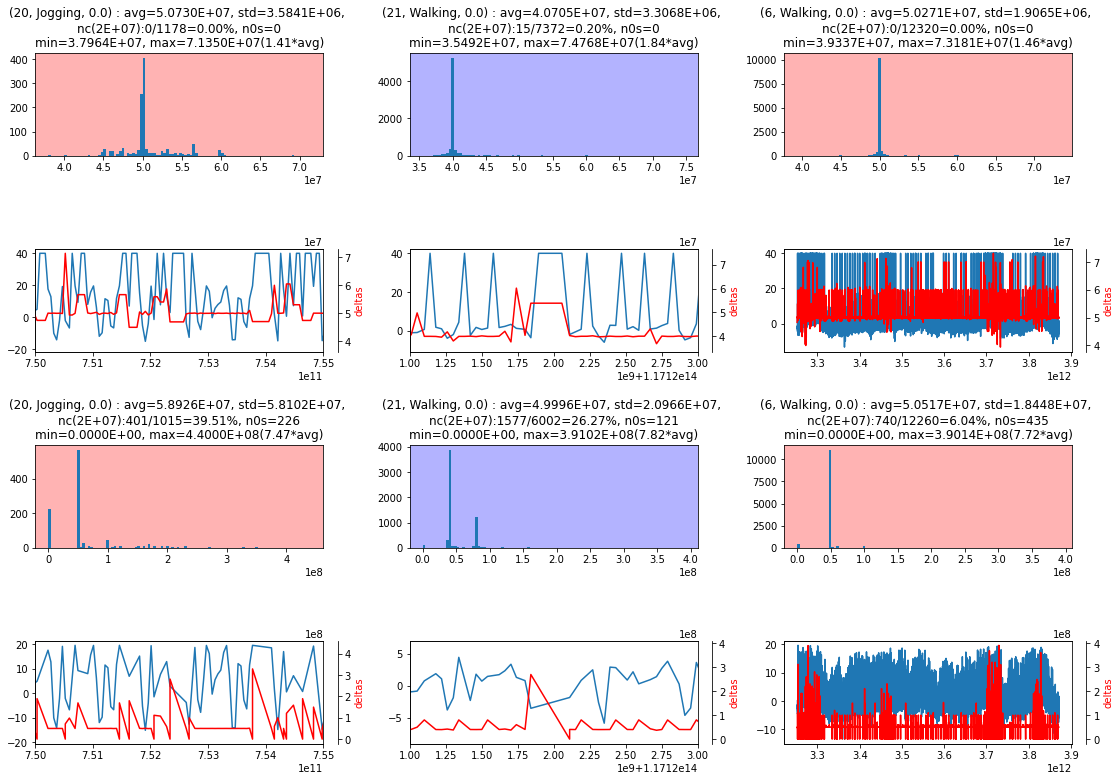

In [ ]:
# Note : Here we use a ridiculous interpolator (constant equal to 40) for demonstration purposes
f, axis = plt.subplots(4, 3)
f.set_figwidth(18)
f.set_figheight(12)
plt.subplots_adjust(
        left=0.1, bottom=0.1, right=0.9, top=0.9,
        wspace=0.3, hspace=0.9)

df_20_Jogging_fs = snap_to_frequency(remove_duplicates(df_20_Jogging_base), 20, "Jogging", 0.0, interpolator=lambda b, e, t: 40) 
df_21_Walking_fs = snap_to_frequency(remove_duplicates(df_21_Walking_base), 20, "Walking", 0.0, interpolator=lambda b, e, t: 40) 
df_6_Walking_fs = snap_to_frequency(remove_duplicates(df_6_Walking_base), 6, "Walking", 0.0, interpolator=lambda b, e, t: 40) 

# After freqsnapping
analyse_deltas(df_20_Jogging_fs, 20, "Jogging", 0.0, axis[0][0], err=2.5 * 10 ** 7)
analyse_deltas_with_values(df_20_Jogging_fs, 20, "Jogging", 0.0, axis[1][0], interv=[7.5 * 10 ** 11, 7.55 * 10 ** 11])
analyse_deltas(df_21_Walking_fs, 21, "Walking", 0.0, axis[0][1], err=2.5 * 10 ** 7)
analyse_deltas_with_values(df_21_Walking_fs, 21, "Walking", 0.0, axis[1][1], interv=[1.17121 * 10 ** 14, 1.17123 * 10 ** 14])
analyse_deltas(df_6_Walking_fs, 6, "Walking", 0.0, axis[0][2], err=2.5 * 10 ** 7)
analyse_deltas_with_values(df_6_Walking_fs, 6, "Walking", 0.0, axis[1][2])

# Before freqsnapping
analyse_deltas(df_20_Jogging_base, 20, "Jogging", 0.0, axis[2][0], err=2.5 * 10 ** 7)
analyse_deltas_with_values(df_20_Jogging_base, 20, "Jogging", 0.0, axis[3][0], interv=[7.5 * 10 ** 11, 7.55 * 10 ** 11])
analyse_deltas(df_21_Walking_base, 21, "Walking", 0.0, axis[2][1], err=2.5 * 10 ** 7)
analyse_deltas_with_values(df_21_Walking_base, 21, "Walking", 0.0, axis[3][1], interv=[1.17121 * 10 ** 14, 1.17123 * 10 ** 14])
analyse_deltas(df_6_Walking_base, 6, "Walking", 0.0, axis[2][2], err=2.5 * 10 ** 7)
analyse_deltas_with_values(df_6_Walking_base, 6, "Walking", 0.0, axis[3][2])

Il est donc maintenant possible de nettoyer complètement les données  
**Attention**, le calcul des valeurs nettoyées est peu optimisé et donc très long (environ 15 minutes). Il n'est à exécuter que pour regénérer le fichier `WISDM_ar_v1.1_freqsnapped.csv` disponible sur `...`

In [ ]:
all_noduplicate_list = []
all_freqsnapped_list = []
for user, activity, sample_index in tqdm(itl.product(range(1, 37), all_activities, np.arange(0.0, float(max_num_samples + 1))), total=3456):
    specific_sample = sub_df(sampled_without_zeros, user, activity, sample_index)
    if specific_sample.empty:
        continue
    noduplicate_sample = remove_duplicates(specific_sample)
    freqsnapped_sample = snap_to_frequency(
        noduplicate_sample, user, activity, sample_index, 
        interpolator=lambda b, e, t: b + (e - b) * t)
    
    all_noduplicate_list.append(noduplicate_sample)
    all_freqsnapped_list.append(freqsnapped_sample)

100%|██████████| 3456/3456 [18:47<00:00,  3.07it/s]


In [ ]:
all_noduplicate_data = pd.concat(all_noduplicate_list, ignore_index=False)
all_freqsnapped_data = pd.concat(all_freqsnapped_list, ignore_index=False)

In [ ]:
all_noduplicate_data.to_csv(f'{WISDM_DIR}/WISDM_ar_v1.1_noduplicate.csv', sep=",", index=False)
all_freqsnapped_data.to_csv(f'{WISDM_DIR}/WISDM_ar_v1.1_freqsnapped.csv', sep=",", index=False)

In [ ]:
# Execute in order to get the freqsnapped data directly:
# WARNING : the "Etude JDD" folder must be set as a shortcut in your MyDrive directory
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/MyDrive/Etude JDD/"$WISDM_NAME"_noduplicate.csv" $WISDM_DIR"/"$WISDM_NAME"_noduplicate.csv"
!cp "/content/drive/MyDrive/Etude JDD/"$WISDM_NAME"_freqsnapped.csv" $WISDM_DIR"/"$WISDM_NAME"_freqsnapped.csv"
all_noduplicate_data = pd.read_csv(f'{WISDM_DIR}/{WISDM_NAME}_noduplicate.csv')
all_freqsnapped_data = pd.read_csv(f'{WISDM_DIR}/{WISDM_NAME}_freqsnapped.csv')

ValueError: ignored

In [ ]:
print(f'Base (raw) points : {len(raw_ts_data)}')
print(f'Noduplicate points : {len(all_noduplicate_data)}')
print(f'Freqsnapped (interpolated) points : {len(all_freqsnapped_data)}')
all_freqsnapped_data

Base (raw) points : 1098208
Noduplicate points : 1030991
Freqsnapped (interpolated) points : 1158054


user    activity     timestamp  x-accel  y-accel   z-accel  \
948765     1     Jogging  5.374662e+12    4.480   14.180 -2.110000   
948766     1     Jogging  5.374712e+12    3.950   12.260 -2.680000   
948767     1     Jogging  5.374762e+12    6.050    9.720 -1.950000   
948768     1     Jogging  5.374812e+12    5.240    7.210 -5.560000   
948769     1     Jogging  5.374862e+12    7.270    5.790 -6.510000   
...      ...         ...           ...      ...      ...       ...   
0         36  Downstairs  1.477541e+13   -2.335   11.825  2.131584   
252895    36  Downstairs  1.477546e+13   -2.910   10.120  2.152015   
252896    36  Downstairs  1.477551e+13   -3.110    9.510  3.568531   
252898    36  Downstairs  1.477557e+13   -5.050    9.110  3.990762   
252899    36  Downstairs  1.477562e+13   -3.300    6.630  1.184970   

        sample_index  snap_index  
948765           0.0           1  
948766           0.0           2  
948767           0.0           3  
948768           0.0           4  
948769           0.0           5  
...              ...         ...  
0                3.0        1070  
252895           3.0        1071  
252896           3.0        1072  
252898           3.0        1073  
252899           3.0        1074  

[1158054 rows x 8 columns]

Une fois le travail de nettoyage effectué, on peut calculer quelques statistiques sur les données ainsi obtenues

In [ ]:
def get_deltas(specific_sample):
    ordered_timestamps = specific_sample["timestamp"].sort_values()
    shift_none = ordered_timestamps[1:len(ordered_timestamps) - 1]
    shift_once = ordered_timestamps.shift(1)[1:len(ordered_timestamps) - 1]
    deltas = shift_none - shift_once
    return deltas

def count_zeros(deltas):
    return len(deltas[deltas == 0])

final_fresqnapped_delta_groupby = all_freqsnapped_data.groupby(
    ["user", "activity", "sample_index"])\
    .apply(get_deltas).groupby(axis=0, level=[0, 1, 2])

final_freqsnapped_delta_stats = pd.concat([
    final_fresqnapped_delta_groupby.mean(),
    final_fresqnapped_delta_groupby.std(),
    final_fresqnapped_delta_groupby.min(),
    final_fresqnapped_delta_groupby.max(),
    final_fresqnapped_delta_groupby.apply(count_zeros),
], axis=1)
final_freqsnapped_delta_stats.columns = ["avg", "std", "min", "max", "n0s"]

final_freqsnapped_ts_groupby = all_freqsnapped_data.groupby(
    ["user", "activity", "sample_index"])["timestamp"]

final_freqsnapped_delta_stats["time_span"] = final_freqsnapped_ts_groupby\
    .apply(lambda group: group.max() - group.min())

print(f'Mean period: {final_freqsnapped_delta_stats["avg"].mean()}')
print(f'Mean delta std: {final_freqsnapped_delta_stats["std"].mean()}')
print(f'Samples with 0 deltas: {final_freqsnapped_delta_stats["n0s"].sum()}')
print(f'Samples with time_span > 10s: {len(final_freqsnapped_delta_stats[final_freqsnapped_delta_stats["time_span"] > 10 ** 10])}')

final_freqsnapped_delta_stats

Mean period: 47699645.127443425
Mean delta std: 2446154.262176825
Samples with 0 deltas: 0
Samples with time_span > 10s: 426


avg           std         min  \
user activity   sample_index                                           
1    Downstairs 0.0           5.024899e+07  1.642156e+06  49530000.0   
                1.0           5.026604e+07  1.968677e+06  49438000.0   
                2.0           5.029411e+07  1.834896e+06  49622000.0   
                3.0           5.027282e+07  1.762060e+06  49652000.0   
     Jogging    0.0           5.091706e+07  3.144450e+06  38116500.0   
...                                    ...           ...         ...   
36   Upstairs   0.0           5.020539e+07  1.377250e+06  49041000.0   
                1.0           5.023184e+07  1.571239e+06  49255000.0   
                2.0           5.021542e+07  1.534038e+06  49286000.0   
                3.0           5.022800e+07  1.668936e+06  48310000.0   
     Walking    0.0           5.023504e+07  1.577365e+06  47516000.0   

                                     max  n0s     time_span  
user activity   sample_index                                 
1    Downstairs 0.0           68024000.0    0  3.638004e+10  
                1.0           70038000.0    0  3.594000e+10  
                2.0           70007000.0    0  3.767996e+10  
                3.0           70038000.0    0  3.689996e+10  
     Jogging    0.0           72693000.0    0  2.499000e+11  
...                                  ...  ...           ...  
36   Upstairs   0.0           70038000.0    0  7.094000e+10  
                1.0           70008000.0    0  6.937000e+10  
                2.0           70099000.0    0  6.065994e+10  
                3.0           70069000.0    0  7.051993e+10  
     Walking    0.0           70160000.0    0  3.099500e+11  

[474 rows x 6 columns]

On remarque que les données sont bien cohérentes, et qu'elles ont en moyenne une fréquence d'échantillonnage (`period`) de 50ms avec un faible écart-type (2.5ms en moyenne) sur les deltas, comme prévu (grâce à l'interpolation).  

Cependant, on peut observer que 140 *samples* sur 474 présentent le défaut expliqué plus haut (`period` proche de 40ms) :

In [ ]:
incorrect_period_samples = final_freqsnapped_delta_stats["avg"].map(lambda x: abs(x - 5 * 10 ** 7) > 0.5 * 10 ** 7)

print(f'samples with incorrect period: {len(final_freqsnapped_delta_stats[incorrect_period_samples])}')
final_freqsnapped_delta_stats[incorrect_period_samples]

samples with incorrect period: 140


avg           std         min  \
user activity   sample_index                                           
3    Downstairs 0.0           4.052225e+07  3.030422e+06  37232000.0   
                1.0           4.056859e+07  2.977030e+06  35584000.0   
                2.0           4.037036e+07  2.335017e+06  37201000.0   
                4.0           4.048149e+07  2.766357e+06  35492000.0   
     Jogging    0.0           4.046694e+07  2.813359e+06  35492000.0   
...                                    ...           ...         ...   
31   Upstairs   2.0           4.044087e+07  2.772690e+06  35187000.0   
     Walking    0.0           4.029612e+07  2.358096e+06  35370000.0   
                1.0           4.046640e+07  2.434955e+06  37262000.0   
                2.0           4.033111e+07  2.481718e+06  35400000.0   
33   Walking    3.0           7.354700e+07           NaN  73547000.0   

                                     max  n0s     time_span  
user activity   sample_index                                 
3    Downstairs 0.0           70740000.0    0  4.039972e+10  
                1.0           72235000.0    0  3.861877e+10  
                2.0           70008000.0    0  4.037009e+10  
                4.0           74006000.0    0  4.643201e+10  
     Jogging    0.0           74982000.0    0  3.648901e+11  
...                                  ...  ...           ...  
31   Upstairs   2.0           70282000.0    0  8.075998e+10  
     Walking    0.0           74280000.0    0  4.496192e+11  
                1.0           59967000.0    0  4.257007e+10  
                2.0           73730000.0    0  3.507998e+11  
33   Walking    3.0           73547000.0    0  1.356200e+08  

[140 rows x 6 columns]

Il sera peut-être nécessaire de les supprimer afin de n'avoir que des données échantillonnées à 50ms, ou de séparer les traitements entre deux groupes

In [ ]:
def multiIndex_selector(multiIndex, df): 
    return reduce(
        lambda x, y: x | y,
        multiIndex.map(
            lambda ind: (df["user"] == ind[0]) & (df["activity"] == ind[1]) & (df["sample_index"] == ind[2])
        )
    )

all_freqsnapped_data.loc[
  multiIndex_selector(
        final_freqsnapped_delta_stats[~incorrect_period_samples].index,
        all_freqsnapped_data),
  "true_period"] = 5 * 10 ** 7

all_freqsnapped_data.loc[
  multiIndex_selector(
        final_freqsnapped_delta_stats[incorrect_period_samples].index,
        all_freqsnapped_data),
  "true_period"] = 4 * 10 ** 7


In [ ]:
print(f'Data points from samples at 50ms: {len(all_freqsnapped_data[all_freqsnapped_data["true_period"] == 5 * 10 ** 7])}')
print(f'Data points from samples at 40ms: {len(all_freqsnapped_data[all_freqsnapped_data["true_period"] == 4 * 10 ** 7])}')
all_freqsnapped_data

Data points from samples at 50ms: 814317
Data points from samples at 40ms: 343732


user    activity     timestamp  x-accel  y-accel   z-accel  \
948765     1     Jogging  5.374662e+12    4.480   14.180 -2.110000   
948766     1     Jogging  5.374712e+12    3.950   12.260 -2.680000   
948767     1     Jogging  5.374762e+12    6.050    9.720 -1.950000   
948768     1     Jogging  5.374812e+12    5.240    7.210 -5.560000   
948769     1     Jogging  5.374862e+12    7.270    5.790 -6.510000   
...      ...         ...           ...      ...      ...       ...   
0         36  Downstairs  1.477541e+13   -2.335   11.825  2.131584   
252895    36  Downstairs  1.477546e+13   -2.910   10.120  2.152015   
252896    36  Downstairs  1.477551e+13   -3.110    9.510  3.568531   
252898    36  Downstairs  1.477557e+13   -5.050    9.110  3.990762   
252899    36  Downstairs  1.477562e+13   -3.300    6.630  1.184970   

        sample_index  snap_index  true_period  
948765           0.0           1   50000000.0  
948766           0.0           2   50000000.0  
948767           0.0           3   50000000.0  
948768           0.0           4   50000000.0  
948769           0.0           5   50000000.0  
...              ...         ...          ...  
0                3.0        1070   50000000.0  
252895           3.0        1071   50000000.0  
252896           3.0        1072   50000000.0  
252898           3.0        1073   50000000.0  
252899           3.0        1074   50000000.0  

[1158054 rows x 9 columns]

Les 5 points manquants proviennent de samples contenant moins de 3 points, qui seront de toute façon éliminés dans l'étape d'élagage des samples (car trop courts pour être utilisables)

In [ ]:
all_freqsnapped_data[all_freqsnapped_data["true_period"].isna()]

user    activity     timestamp  x-accel  y-accel   z-accel  \
902564     3  Downstairs  1.032138e+14     0.80     7.82  2.340000   
902565     3  Downstairs  1.032139e+14     0.23     9.00  1.920000   
643364    12    Upstairs  1.899801e+13    -3.72     7.50  2.640000   
643365    12    Upstairs  1.899805e+13    -2.18     6.17 -1.330000   
161709    15  Downstairs  2.035402e+12    -4.94     8.31 -1.266692   

        sample_index  snap_index  true_period  
902564           3.0           1          NaN  
902565           3.0           2          NaN  
643364           1.0           1          NaN  
643365           1.0           2          NaN  
161709           7.0           1          NaN

Il restera ensuite à élaguer les *samples* trop courts. Afin que le critère d'élagage puisse être modulable, on peut ajouter à chaque point l'étendue des timestamps de son *sample*  

On peut remarquer que pour ne conserver que les *samples* de plus de 10s, on ne doit supprimer qu'environ 6000 points

In [ ]:
if "time_span" in all_freqsnapped_data.columns:
    all_freqsnapped_data = all_freqsnapped_data.drop(columns=["time_span"])
all_freqsnapped_data = all_freqsnapped_data.join(final_freqsnapped_delta_stats["time_span"], on=["user", "activity", "sample_index"])
all_freqsnapped_data.loc[all_freqsnapped_data["time_span"].isna(), "time_span"] = 0

samples_tooshort = all_freqsnapped_data[all_freqsnapped_data["time_span"] <= 10 ** 10 - 1][["user", "activity", "sample_index", "time_span"]]\
    .drop_duplicates()
print(f'Data points from samples with time_span >= 10s: {len(all_freqsnapped_data[all_freqsnapped_data["time_span"] >= 10 ** 10 - 1])}')
print(f'Samples with time_span < 10s : {len(samples_tooshort)}')
samples_tooshort

Data points from samples with time_span >= 10s: 1152084
Samples with time_span < 10s : 50


user    activity  sample_index     time_span
893937      3    Standing           0.0  2.349976e+09
902564      3  Downstairs           3.0  0.000000e+00
682672      4    Upstairs           0.0  5.459931e+09
682573      4  Downstairs           1.0  4.419892e+09
682663      4  Downstairs           2.0  4.201660e+08
187006      6    Upstairs           0.0  6.589996e+09
189516      6    Upstairs           6.0  9.920044e+09
187138      6  Downstairs           0.0  6.710052e+09
189315      6  Downstairs           5.0  9.959930e+09
189715      6  Downstairs           6.0  9.370453e+09
1023728     7     Jogging           2.0  5.850067e+09
1024118     7     Jogging           4.0  8.650360e+09
1025316     7     Jogging           6.0  6.330413e+09
1026215     7     Jogging           8.0  3.490479e+09
769748      8     Jogging           1.0  8.299804e+09
643364     12    Upstairs           1.0  0.000000e+00
644639     12  Downstairs           2.0  6.999238e+09
159806     15    Upstairs           2.0  9.799987e+09
160182     15    Upstairs           3.0  8.930054e+09
160540     15    Upstairs           4.0  9.819977e+09
160880     15    Upstairs           5.0  8.449982e+09
161202     15    Upstairs           6.0  8.909973e+09
161532     15    Upstairs           7.0  8.859436e+09
161853     15    Upstairs           8.0  8.920044e+09
162157     15    Upstairs           9.0  8.489990e+09
162452     15    Upstairs          10.0  9.240051e+09
160003     15  Downstairs           2.0  8.940094e+09
160361     15  Downstairs           3.0  8.880005e+09
160737     15  Downstairs           4.0  7.070038e+09
161050     15  Downstairs           5.0  7.540040e+09
161381     15  Downstairs           6.0  7.480438e+09
161709     15  Downstairs           7.0  0.000000e+00
161710     15  Downstairs           8.0  7.079986e+09
162032     15  Downstairs           9.0  6.229919e+09
162327     15  Downstairs          10.0  6.219971e+09
162638     15  Downstairs          11.0  7.500031e+09
257964     18     Jogging           1.0  8.590790e+09
271111     18     Jogging           9.0  2.640167e+09
271176     18     Jogging          10.0  5.850006e+09
271302     18     Jogging          11.0  5.056701e+09
271409     18     Jogging          12.0  3.600159e+09
271489     18     Jogging          13.0  2.769928e+09
33736      20     Jogging           2.0  7.490020e+09
938219     22  Downstairs           1.0  2.496030e+08
304641     32     Jogging           3.0  4.942138e+09
312588     32  Downstairs           3.0  3.268646e+09
593        33     Jogging           1.0  2.527770e+08
6107       33     Jogging           3.0  1.009643e+09
1158       33     Walking           3.0  1.356200e+08
6689       33     Walking           5.0  6.900020e+08

### **Données Complètes Nettoyées**

Une fois l'ensemble des étapes décrites effectuées:
- points aberrants
- découpage en prises de vues
- élimination des points dupliqués
- interpolation
- élagage des samples

nous pouvons enregistrer les données complètes nettoyées

In [ ]:
all_freqsnapped_data.to_csv(
    f'{WISDM_DIR}/WISDM_ar_v1.1_complete_cleaned_2022(nonzero,sampled,nodups,interp,withspan).csv', 
    sep=",", index=False)

Les données csv sont disponibles **ici** *(nécessite pour l'instant un lien MyDrive vers le dossier Etude JDD du projet ECOFAST)*  

In [ ]:
!cp "/content/drive/MyDrive/Etude JDD/"$WISDM_NAME"_complete_cleaned_2022(nonzero,sampled,nodups,interp,withspan).csv" $WISDM_DIR"/"$WISDM_NAME"_complete_cleaned_2022(nonzero,sampled,nodups,interp,withspan).csv"
complete_cleaned_data = pd.read_csv(f'{WISDM_DIR}/{WISDM_NAME}_complete_cleaned_2022(nonzero,sampled,nodups,interp,withspan).csv')

complete_cleaned_data

cp: cannot stat '/content/drive/MyDrive/Etude JDD/WISDM_ar_v1.1_complete_cleaned_2022(nonzero,sampled,nodups,interp,withspan).csv': No such file or directory


user    activity     timestamp  x-accel  y-accel   z-accel  \
0           1     Jogging  5.374662e+12    4.480   14.180 -2.110000   
1           1     Jogging  5.374712e+12    3.950   12.260 -2.680000   
2           1     Jogging  5.374762e+12    6.050    9.720 -1.950000   
3           1     Jogging  5.374812e+12    5.240    7.210 -5.560000   
4           1     Jogging  5.374862e+12    7.270    5.790 -6.510000   
...       ...         ...           ...      ...      ...       ...   
1158049    36  Downstairs  1.477541e+13   -2.335   11.825  2.131584   
1158050    36  Downstairs  1.477546e+13   -2.910   10.120  2.152015   
1158051    36  Downstairs  1.477551e+13   -3.110    9.510  3.568531   
1158052    36  Downstairs  1.477557e+13   -5.050    9.110  3.990762   
1158053    36  Downstairs  1.477562e+13   -3.300    6.630  1.184970   

         sample_index  snap_index  true_period     time_span  
0                 0.0           1   50000000.0  2.499000e+11  
1                 0.0           2   50000000.0  2.499000e+11  
2                 0.0           3   50000000.0  2.499000e+11  
3                 0.0           4   50000000.0  2.499000e+11  
4                 0.0           5   50000000.0  2.499000e+11  
...               ...         ...          ...           ...  
1158049           3.0        1070   50000000.0  5.388058e+10  
1158050           3.0        1071   50000000.0  5.388058e+10  
1158051           3.0        1072   50000000.0  5.388058e+10  
1158052           3.0        1073   50000000.0  5.388058e+10  
1158053           3.0        1074   50000000.0  5.388058e+10  

[1158054 rows x 10 columns]

## **Stratégies de création d'exemples d'apprentissage**

L'article décrit une stratégie utilisée pour convertir les prises continues en *exemples* (données d'entrées utilisées pour la classification) : On découpe la série en sous-séries de durée fixée (10s), chaque sous-série correspond alors à un exemple.  

Plusieurs méthodes existent pour effectuer ce découpage. Nous utiliseraons la plus simple : le découpage d'intersection nulle (no overlap).  

Une fois les exemples générés (en ajoutant à chaque ligne du dataframe l'identifiant de son exemple au sein d'un *sample*), il est nécessaire de retirer ceux ne contenant pas le bon nombre de points. Ces exemples problématiques seront toujours les derniers générés pour chaque *sample*, s'il n'y a pas assez de points pour construire un exemple de la taille attendue. Le nombre de points attendus dépend de la famille (50ms ou 60ms) du *sample*

In [ ]:



def apply_example_strategy(specific_sample, strategy, points=None, duration=None, period=None):
    """
      Applies an example partitioning strategy to a sample's dataframe. Data is partitioned into examples of dimension num_points.
      If num_points is not given, it is computed from a wanted duration and supposed period.
    """
    try:
        num_points = points if points is not None else int(duration / period)
        start_index = specific_sample.index[0]
        return specific_sample.index.map(lambda i: strategy(i - start_index, num_points))
    except ValueError:
        print("error")

def generate_examples(df, strategy, example_duration=None, num_points=None):
    """
      Applies an example partitioning strategy to the full dataframe, by applying the strategy to each sample.
      If the partitioning is done by duration, the period is computed from the dataframe itself.
    """
    groupby_samples = df.groupby(["user", "activity", "sample_index"])
    if num_points is None:
        res = groupby_samples.apply(lambda group: pd.Series(apply_example_strategy(
            group, strategy, duration=example_duration, period=group["true_period"].iat[0]
            ), group.index))
    else:
        res = groupby_samples.apply(lambda group: pd.Series(apply_example_strategy(
            group, strategy, points=num_points
            ), group.index))
    
    return res.reindex(res.index.set_names(["_1", "_2", "_3", "true_index"])).droplevel(["_1", "_2", "_3"])


In [ ]:
def remove_incomplete_examples(df, vector_size):
    """
      removes the last example from a dataframe if its size is not equal to 'vector_size'
    """

    # Calculate the last example's id and size for each key (user, activity, sample_index)
    by_samples = df.groupby(["user", "activity", "sample_index"])
    last_example_sizes = pd.concat([
        pd.Series(
            data=by_samples.apply(
                lambda sample: sample["example_index"].max()
            ), name="last_ex_id"
        ),
        pd.Series(
            data=by_samples.apply(
                lambda sample: len(sample[sample["example_index"] == sample["example_index"].max()])
            ), name="last_ex_size"
        )
    ], axis=1)

    # Remove entries corresponding to the last example, when the last example's size is not 'vector_size'
    to_remove = last_example_sizes[last_example_sizes["last_ex_size"] != vector_size]["last_ex_id"]
    result = df.join(to_remove, on=["user", "activity", "sample_index"])
    result = result[result["example_index"] != result["last_ex_id"]]\
      .drop(columns=["last_ex_id"])

    return result

### **Découpage par intervalles d'intersection nulle**

Cette stratégie consiste à découper chaque prise de donnée en exemples *(bins)* formant une partition de l'intervalle de prise de données. Ce découpage est simpliste mais suffisant pour nos utilisations (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6891351/)

In [ ]:

def no_overlap_bins(index, num_points):
    return int(index / num_points)

In [ ]:
# Here, we create examples with a fixed 'duration' (10s), so the two different families of samples (50ms and 40ms) will have different vector sizes
example_cleaned_data = complete_cleaned_data[complete_cleaned_data["time_span"] > 0].copy()
example_cleaned_data["example_index"] = generate_examples(example_cleaned_data, no_overlap_bins, example_duration = 10 ** 10)#num_points=200)
example_cleaned_data

user    activity     timestamp  x-accel  y-accel   z-accel  \
0           1     Jogging  5.374662e+12    4.480   14.180 -2.110000   
1           1     Jogging  5.374712e+12    3.950   12.260 -2.680000   
2           1     Jogging  5.374762e+12    6.050    9.720 -1.950000   
3           1     Jogging  5.374812e+12    5.240    7.210 -5.560000   
4           1     Jogging  5.374862e+12    7.270    5.790 -6.510000   
...       ...         ...           ...      ...      ...       ...   
1158049    36  Downstairs  1.477541e+13   -2.335   11.825  2.131584   
1158050    36  Downstairs  1.477546e+13   -2.910   10.120  2.152015   
1158051    36  Downstairs  1.477551e+13   -3.110    9.510  3.568531   
1158052    36  Downstairs  1.477557e+13   -5.050    9.110  3.990762   
1158053    36  Downstairs  1.477562e+13   -3.300    6.630  1.184970   

         sample_index  snap_index  true_period     time_span  example_index  
0                 0.0           1   50000000.0  2.499000e+11              0  
1                 0.0           2   50000000.0  2.499000e+11              0  
2                 0.0           3   50000000.0  2.499000e+11              0  
3                 0.0           4   50000000.0  2.499000e+11              0  
4                 0.0           5   50000000.0  2.499000e+11              0  
...               ...         ...          ...           ...            ...  
1158049           3.0        1070   50000000.0  5.388058e+10              5  
1158050           3.0        1071   50000000.0  5.388058e+10              5  
1158051           3.0        1072   50000000.0  5.388058e+10              5  
1158052           3.0        1073   50000000.0  5.388058e+10              5  
1158053           3.0        1074   50000000.0  5.388058e+10              5  

[1158049 rows x 11 columns]

In [ ]:
TRUE_VECTOR_SIZE = {
    50: sub_df(example_cleaned_data[example_cleaned_data["example_index"] == 0], 1, "Jogging", 1.0)["snap_index"].max(),
    40: sub_df(example_cleaned_data[example_cleaned_data["example_index"] == 0], 3, "Jogging", 1.0)["snap_index"].max()
}

TRUE_VECTOR_SIZE

{50: 200, 40: 250}

In [ ]:
len(example_cleaned_data.groupby(["user", "activity", "sample_index", "example_index"]))

5676

In [ ]:
final_examples = {
    50: remove_incomplete_examples(
          example_cleaned_data[example_cleaned_data["true_period"] == 50 * 10 ** 6], 
          TRUE_VECTOR_SIZE[50]),
    40: remove_incomplete_examples(
          example_cleaned_data[example_cleaned_data["true_period"] == 40 * 10 ** 6],
          TRUE_VECTOR_SIZE[40])
    }

NameError: ignored

In [ ]:
print(f'final examples (50ms) : {len(final_examples[50].groupby(["user", "activity", "sample_index", "example_index"]))}')
final_examples[50]

final examples (50ms) : 3900


user    activity     timestamp  x-accel  y-accel   z-accel  \
0           1     Jogging  5.374662e+12     4.48    14.18 -2.110000   
1           1     Jogging  5.374712e+12     3.95    12.26 -2.680000   
2           1     Jogging  5.374762e+12     6.05     9.72 -1.950000   
3           1     Jogging  5.374812e+12     5.24     7.21 -5.560000   
4           1     Jogging  5.374862e+12     7.27     5.79 -6.510000   
...       ...         ...           ...      ...      ...       ...   
1157975    36  Downstairs  1.477169e+13    -1.88     7.55  1.797886   
1157976    36  Downstairs  1.477174e+13    -3.15     6.51  2.369940   
1157977    36  Downstairs  1.477179e+13    -3.95     7.35  2.533385   
1157978    36  Downstairs  1.477184e+13    -1.99     7.82  1.648062   
1157979    36  Downstairs  1.477189e+13    -2.68     9.70  2.301839   

         sample_index  snap_index  true_period     time_span  example_index  
0                 0.0           1   50000000.0  2.499000e+11              0  
1                 0.0           2   50000000.0  2.499000e+11              0  
2                 0.0           3   50000000.0  2.499000e+11              0  
3                 0.0           4   50000000.0  2.499000e+11              0  
4                 0.0           5   50000000.0  2.499000e+11              0  
...               ...         ...          ...           ...            ...  
1157975           3.0         996   50000000.0  5.388058e+10              4  
1157976           3.0         997   50000000.0  5.388058e+10              4  
1157977           3.0         998   50000000.0  5.388058e+10              4  
1157978           3.0         999   50000000.0  5.388058e+10              4  
1157979           3.0        1000   50000000.0  5.388058e+10              4  

[780000 rows x 11 columns]

In [ ]:
print(f'final examples (40ms) : {len(final_examples[40].groupby(["user", "activity", "sample_index", "example_index"]))}')
final_examples[40]

final examples (40ms) : 1303


user    activity     timestamp  x-accel  y-accel  z-accel  \
53109      3     Jogging  1.012362e+14    -0.93   -1.570    -3.15   
53110      3     Jogging  1.012363e+14     0.69   -4.860    -2.98   
53111      3     Jogging  1.012363e+14     1.34    1.460     4.14   
53112      3     Jogging  1.012363e+14     1.99    7.780    11.26   
53113      3     Jogging  1.012364e+14    -9.08    5.050    -8.12   
...      ...         ...           ...      ...      ...      ...   
994481    31  Downstairs  2.486764e+13     4.40    2.960     2.37   
994482    31  Downstairs  2.486768e+13     8.69    2.030     7.50   
994483    31  Downstairs  2.486772e+13     6.02    4.750    -0.53   
994484    31  Downstairs  2.486776e+13     7.70    4.995    -0.61   
994485    31  Downstairs  2.486780e+13     9.38    5.240    -0.69   

        sample_index  snap_index  true_period     time_span  example_index  
53109            0.0           1   40000000.0  3.648901e+11              0  
53110            0.0           2   40000000.0  3.648901e+11              0  
53111            0.0           3   40000000.0  3.648901e+11              0  
53112            0.0           4   40000000.0  3.648901e+11              0  
53113            0.0           5   40000000.0  3.648901e+11              0  
...              ...         ...          ...           ...            ...  
994481           2.0        1496   40000000.0  6.364004e+10              5  
994482           2.0        1497   40000000.0  6.364004e+10              5  
994483           2.0        1498   40000000.0  6.364004e+10              5  
994484           2.0        1499   40000000.0  6.364004e+10              5  
994485           2.0        1500   40000000.0  6.364004e+10              5  

[325750 rows x 11 columns]

### **Export au format ARFF**  

Les exemples peuvent être exportés au format **ARFF** (Attribute-Relation File Format), format classique d'échange utilisé pour les Séries Temporelles.  

Les séries sont multivariées, il existe donc plusieurs manières d'obtenir des relations ARFF :
- concaténer les vecteurs de chaque axe (on aura les valeurs de x puis les valeurs de y puis les valeurs de z)
- alterner les coordonnées x y et z
- exporter chaque composante en une relation différente (trois fichiers ARFF par exemple d'apprentissage)  

In [ ]:
def flatten_example(specific_example, val_mapper, target, cols=["x-accel", "y-accel", "z-accel"]):
    """
      Flattens the multivariate sequence into a single vector by concatenating the
      vectors for each component (x then y the z)
    """
    sequenced_vals = pd.DataFrame(
        pd.concat(
            [specific_example[col] for col in cols], 
            axis=0, ignore_index=True
        ))
    
    flattened_vals = sequenced_vals\
      .set_index(sequenced_vals.index.map(val_mapper))\
      .transpose()

    flattened_vals["target"] = target

    return flattened_vals

In [ ]:
def unflatten_example(flattened_example, val_unwrapper, key_cols, key_value, target, new_index=None):
    upright = flattened_example[
        [col for col in flattened_example.columns if col != "target"]
    ].transpose()
    upright["index_val"] = upright.index.map(val_unwrapper)

    groupby_dim = upright.groupby(["index_val"])

    new_index = np.arange(0, len(upright) // len(groupby_dim)) if new_index is None else new_index
    dimensions = [pd.DataFrame(g[1][0]).set_index(new_index) for g in groupby_dim]
    columns = [g[0] for g in groupby_dim]

    res = pd.concat(dimensions, axis=1, ignore_index=True)
    res.columns = columns
    for key, val in zip(key_cols, key_value):
        res[key] = val
    res[target] = flattened_example["target"].loc[0]
    return res


In [ ]:
def dimension_mapper(flattened_size, dim_cols, prefix):
    dim_size = flattened_size // len(dim_cols)
    return lambda s: dim_cols[int(s.strip(prefix)) // dim_size]

In [ ]:
flattened_test = flatten_example(example1, lambda x: f'att{x}', "abc")
unflatten_example(
    flattened_test, 
    dimension_mapper(len(flattened_test.columns) - 1, ["x-accel", "y-accel", "z-accel"], "att"),
    ["user", "sample_index", "example_index"], [1, 2, 3], "activity"
)

NameError: ignored

In [ ]:
flattened_final_examples = {
    50: final_examples[50]\
          .groupby(["user", "activity", "sample_index", "example_index"])\
          .apply(lambda example: flatten_example(
              example, lambda x: f'att{x}', 
              example.name[1]
          )),
    40: final_examples[40]\
          .groupby(["user", "activity", "sample_index", "example_index"])\
          .apply(lambda example: flatten_example(
              example, lambda x: f'att{x}', 
              example.name[1]
          )),
    }

NameError: ignored

In [ ]:
flattened_final_examples[50]

att0   att1  att2  att3   att4  \
user activity   sample_index example_index                                     
1    Downstairs 0.0          0             0 -0.15   0.11 -4.06 -2.87  -0.19   
                             1             0 -8.39  -9.72 -7.93 -8.96  -5.56   
                             2             0 -9.38 -12.68 -9.77 -7.21  -5.18   
                1.0          0             0  4.63   2.15  0.00 -0.19  -1.12   
                             1             0  2.11  -7.82 -7.31 -8.16 -10.61   
...                                            ...    ...   ...   ...    ...   
36   Walking    0.0          25            0  1.38  -0.34 -2.11 -3.60  -2.53   
                             26            0 -0.57  -0.11 -0.65 -0.15   0.42   
                             27            0  2.83   0.57 -1.27 -0.27  -0.19   
                             28            0  3.49   4.18 -2.96 -2.14  -0.84   
                             29            0 -0.04   3.45  1.31 -0.04  -1.23   

                                              att5   att6    att7   att8  \
user activity   sample_index example_index                                 
1    Downstairs 0.0          0             0 -0.19  -1.73  -3.300  -5.05   
                             1             0 -4.90 -16.17 -18.050  -6.66   
                             2             0 -4.02  -2.83  -7.590 -10.08   
                1.0          0             0 -9.70  -8.81  -2.070   3.53   
                             1             0 -6.21   5.75  -4.400 -10.04   
...                                            ...    ...     ...    ...   
36   Walking    0.0          25            0  1.31   1.95  -6.550   2.76   
                             26            0  0.08  -1.84  -1.990  -3.02   
                             27            0  0.80   0.15  -0.465  -1.08   
                             28            0 -0.53  -1.76  -4.750   1.27   
                             29            0 -0.84   0.31  -0.420  -1.31   

                                               att9  ...     att591    att592  \
user activity   sample_index example_index           ...                        
1    Downstairs 0.0          0             0  -1.12  ...  -5.520000 -0.150000   
                             1             0  -2.87  ...  11.750000  0.650000   
                             2             0  -3.98  ...  -1.990000 -3.760000   
                1.0          0             0   9.77  ...  -0.110000  4.520000   
                             1             0 -12.41  ...  10.800000  0.150000   
...                                             ...  ...        ...       ...   
36   Walking    0.0          25            0   0.76  ...  -0.653777  0.231546   
                             26            0  -0.61  ...   2.301839 -1.566340   
                             27            0  -2.37  ...  -1.525479 -0.190685   
                             28            0   0.00  ...  -1.266692  0.463092   
                             29            0  -1.50  ...   0.762740  1.144109   

                                                att593    att594    att595  \
user activity   sample_index example_index                                   
1    Downstairs 0.0          0             0  0.840000 -0.340000 -2.180000   
                             1             0  4.250000  2.680000 -3.450000   
                             2             0  7.780000  7.080000 -2.140000   
                1.0          0             0  2.790000 -5.790000 -1.990000   
                             1             0  0.190000 -1.120000 -0.890000   
...                                                ...       ...       ...   
36   Walking    0.0          25            0  0.313268  0.994285 -0.108963   
                             26            0 -0.081722  0.531194  0.926184   
                             27            0  0.081722  0.463092  0.081722   
                             28            0 -0.531194 -0.381370  0.885323   
                          

In [ ]:
flattened_final_examples[40]

att0   att1   att2  att3   att4  \
user activity   sample_index example_index                                      
3    Downstairs 0.0          0             0  5.37  8.390  3.760  0.46  2.970   
                             1             0 -2.83 -0.110  4.060  7.70  6.705   
                             2             0  9.53  6.755  3.980  6.05  6.630   
                1.0          0             0 -2.76 -1.140 -0.950 -2.60 -3.615   
                             1             0  1.46 -0.890 -1.630 -2.37  0.720   
...                                            ...    ...    ...   ...    ...   
31   Walking    2.0          29            0  0.27  0.380  0.270  0.69 -0.805   
                             30            0  0.38  0.040  0.040  0.61  0.040   
                             31            0 -2.68 -4.060 -3.170 -2.41 -1.650   
                             32            0 -4.56 -3.910 -3.150 -1.12  0.910   
                             33            0 -5.05 -7.060 -5.465 -3.87 -5.790   

                                               att5  att6  att7   att8   att9  \
user activity   sample_index example_index                                      
3    Downstairs 0.0          0             0   5.48  6.24  4.06  4.590  4.820   
                             1             0   5.71  4.75  5.67  7.740  7.695   
                             2             0   4.18  1.73  1.18 -0.230  1.610   
                1.0          0             0  -4.63 -5.09 -0.11 -3.260 -2.815   
                             1             0  10.08  0.99  0.59  0.190  1.650   
...                                             ...   ...   ...    ...    ...   
31   Walking    2.0          29            0  -2.30 -1.92  1.33  2.980  2.105   
                             30            0  -0.53 -0.69  2.22  2.300  2.935   
                             31            0  -2.91 -1.50 -0.27 -0.420 -0.570   
                             32            0   3.57 -1.61 -1.38 -1.305 -1.230   
                             33            0  -3.45 -1.14 -0.99 -0.840  0.000   

                                              ...  att741  att742  att743  \
user activity   sample_index example_index    ...                           
3    Downstairs 0.0          0             0  ...    1.50   1.230    0.11   
                             1             0  ...   -6.09  -6.050   -3.21   
                             2             0  ...   12.95   4.465   -4.02   
                1.0          0             0  ...    4.86   1.645   -1.57   
                             1             0  ...    0.27  -1.990    4.59   
...                                           ...     ...     ...     ...   
31   Walking    2.0          29            0  ...   13.53  10.880    2.41   
                             30            0  ...   -2.03  -1.690    3.34   
                             31            0  ...   -0.34  -2.790   -2.95   
                             32            0  ...   -4.06  -2.125   -0.19   
                             33            0  ...   -1.92  -2.820   -3.72   

                                              att744  att745  att746  att747  \
user activity   sample_index example_index                                     
3    Downstairs 0.0          0             0   -1.73   -1.50   -1.27  10.720   
                             1             0   -2.27   -1.33   -0.72  -0.310   
                             2             0   -3.95   -2.45   -1.04  -0.615   
                1.0          0             0   -1.50    6.93    4.67   6.490   
                             1             0    4.21    5.21    6.21   7.010   
...                                              ...     ...     ...     ...   
31   Walking    2.0          29            0    1.28    0.15   -2.26  -2.180   
                             30            0    3.34    3.34   13.57   0.760   
                             31            0   -3.11   -1.04   17.62   2.560   
                             32            0   -1.54   -

Il reste ensuite à exporter au format ARFF, en inculant les informations essentielles

In [ ]:
ARFF_DESC_50ms="""
WISDM_ar_v1.1 dataset (cleaned 2022) examples
Original dataset : Activity Recognition using Cell Phone Accelerometers - Kwapisz et al. (2010)
(https://www.cis.fordham.edu/wisdm/dataset.php)
Cleanup : INSA Rennes - Inria (ECOFAST 2022 project)
--Description--
This dataset describes cellphone accelerometer mesurements over 10s for
different activities. Attributes att0 to att199 describe the x component,
att200 to att399 the y component and att400 to att599 the z component. Each 
component is sampled at a 50ms period (20 Hz).
Attribut 'target' is the activity.
"""

ARFF_DESC_40ms="""
WISDM_ar_v1.1 dataset (cleaned 2022) examples
Original dataset : Activity Recognition using Cell Phone Accelerometers - Kwapisz et al. (2010)
(https://www.cis.fordham.edu/wisdm/dataset.php)
Cleanup : INSA Rennes - Inria (ECOFAST 2022 project)
--Description--
This dataset describes cellphone accelerometer mesurements over 10s for
different activities. Attributes att0 to att249 describe the x component,
att250 to att499 the y component and att500 to att749 the z component. Each 
component is sampled at a 40ms period (25 Hz).
Attribut 'target' is the activity.
"""

In [ ]:
with open(f'{WISDM_NAME}_final_examples_50ms.arff', 'w') as f:
    arff.dump({
        'description': ARFF_DESC_50ms,
        'relation': WISDM_NAME,
        'attributes': [
            (j, 'NUMERIC') for j in flattened_final_examples[50].columns.values[:-1]
        ] + [('target', all_activities)],
        'data': flattened_final_examples[50].values
    }, f)

with open(f'{WISDM_NAME}_final_examples_40ms.arff', 'w') as f:
    arff.dump({
        'description': ARFF_DESC_40ms,
        'relation': WISDM_NAME,
        'attributes': [
            (j, 'NUMERIC') for j in flattened_final_examples[40].columns.values[:-1]
        ] + [('target', all_activities)],
        'data': flattened_final_examples[40].values
    }, f)

In [ ]:
!cp $WISM_NAME*.arff $WISDM_DIR/

## **Etude statistique générale**  

### **Changement de représentation**
La classe suivante permet de transformer un DatFrame au format "données complètes" (1 ligne = 1 point d'une série, filtrage via une clé pour obtenir tous les points d'une série) en DataFrame au format "changement de représentation" (1 ligne = un vecteur représentant un exemple d'apprentissage dont les composantes sont définies comme dans l'article WISDM) :

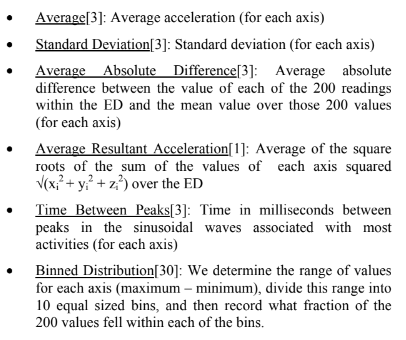

In [ ]:
class TSRepresentation:
    """
      Defines the change of representation of a Time Series Dataframe
    """
    def __init__(self, df, cols, group_key=None, class_name=None, num_bins=10):
        """
          Creates the TSRepresentation object from a dataframe, the list of attributes (cols),
          i.e the dimensions of the variables (here x-accel, y-accel, z-accel) and the key
          used to identify an example in the dataframe (here user, activity, sample_index, example_index) 
        """

        # Sets the dataframe data used to group the time series
        self.df = df
        self.cols = cols
        self.group_key = group_key
        self.class_identifier = group_key.index(class_name)

        # Defines the univariate components (functions computed on each variable)
        self.univ_maps = [
            self.average, self.standard_deviation, 
            self.avg_absolute_difference,
            self.time_between_peaks
        ]

        # Defines the multivariate components (functions computed on all variables at the same time)
        self.multiv_maps = [
            self.avg_result_accel
        ]

        # Defines the 'special' maps, i.e specific functions which do not fit in the previous categories
        # Here, special maps correspond to all 30 'binned distribution' functions
        self.special_maps = [
            (lambda ts, c=c, i=i: self.binned_distrib(ts[c], num_bins, i), f'{c}-binned_distrib-{i}')
            for i in range(num_bins) for c in self.cols
        ]

        # The object contains (once it has been computed) the change of representation,
        # i.e the dataframe containing one vector for each example
        self.representation = None

        # Defines 'displayers', i.e functions which display a single component on a pyplot axis
        # This is used for debugging purposes (no point in understaning how it works)
        self.displayers = [
            lambda ax, vec, col: ax.axhline(vec[f'{col}-average'], c='g'),
            lambda ax, vec, col: ax.axhline(vec[f'{col}-average'] + vec[f'{col}-standard_deviation'], c='r'),
            lambda ax, vec, col: ax.axhline(vec[f'{col}-average'] - vec[f'{col}-standard_deviation'], c='r'),
            lambda ax, vec, col: ax.vlines(
                0, vec[f'{col}-average'] - vec[f'{col}-avg_absolute_difference'], 
                vec[f'{col}-average'] + vec[f'{col}-avg_absolute_difference']
            ),
            lambda ax, vec, col: ax.hlines(
                vec[f'{col}-average'] - vec[f'{col}-avg_absolute_difference'] / 2,
                0, vec[f'{col}-time_between_peaks']
            )
        ] + [
            lambda ax, vec, col, i=i: ax.add_patch(Rectangle(
                  (i * 200 / num_bins, vec[f'{col}-average']), 
                  200 / num_bins, 
                  vec[f'{col}-binned_distrib-{i}'] / max(vec[[f'{col}-binned_distrib-{j}' for j in range(num_bins)]]),
                  fc=(1, 0, 0, 0.3) 
             )) for i in range(num_bins)
        ]
        pass

    def get_representation(self):
        """
          Returns the change of representation, or computes it if it 
          has not been computed.
        """
        if self.representation is not None:
            return self.representation

        if self.group_key == None:
            return

        # Group the dataframe into examples (1 group = 1 time series)
        groupby = self.df.groupby(self.group_key)
        rep_components = []


        num_maps = len(self.cols) * len(self.univ_maps) + len(self.multiv_maps) + len(self.special_maps)
        with tqdm(total=num_maps) as pbar:
            # Compute the univariate components for each example
            for col in self.cols:
                for umap in self.univ_maps:
                    res = groupby.apply(lambda g: umap(g[col]))
                    renamed = res.rename(f'{col}-{umap.__name__}')
                    rep_components.append(
                        renamed
                    )
                    pbar.update(1)

            # Compute the multivariate components for each example
            for mmap in self.multiv_maps:
                rep_components.append(groupby.apply(mmap).rename(f'{mmap.__name__}'))
                pbar.update(1)

            # Compute the special components for each example
            for (smap, sname) in self.special_maps:
                rep_components.append(groupby.apply(smap).rename(f'{sname}'))
                pbar.update(1)

        # Add the class as a final component in the change of representation
        rep_components.append(groupby.apply(lambda g: g.name[self.class_identifier]).rename("class"))

        self.representation = pd.concat(rep_components, axis=1)
        return self.representation

    def display_tsr(self, key, val_cols):
        """
         Displays one example (defined by the given key) using the displayer objects
        """
        if self.representation is None:
            raise RuntimeError("invalid representation")
        
        f, ax = plt.subplots(3, 1)
        f.set_figwidth(18)
        f.set_figheight(10)
        selector = reduce(
            lambda k, agg: k & agg,
            map(
                lambda kp: self.df[kp[0]] == kp[1],
                zip(self.group_key, key)
            )
        )
        multiv_ts = self.df[selector][val_cols]
        tsr_vector = self.representation.loc[key, :]
        print(tsr_vector)
        indices = np.arange(0, len(multiv_ts))
        for i in range(len(val_cols)):
            ax[i].plot(indices, multiv_ts[val_cols[i]])
            for displayer in self.displayers:
                displayer(ax[i], tsr_vector, val_cols[i])

    # The following methods define components abstractly 
    # (each univariate, multivariate and special maps are defined using these methods)

    def average(self, univ_ts):
        """
          Returns the average of a univariate time series
        """
        return univ_ts.mean()

    def standard_deviation(self, univ_ts):
        """
          Returns the standard deviation of a univariate time series
        """
        return univ_ts.std()

    def avg_absolute_difference(self, univ_ts):
        """
          Returns the average absolute difference of a univariate time series
          i.e the average difference between its points and the mean value
        """
        differences = univ_ts - univ_ts.mean()
        return differences.map(np.abs).mean()

    def avg_result_accel(self, multiv_ts, axes=None):
        """
          Returns the average result acceleration of a multivariate time series
          i.e the average L2 norm of its points
        """
        axes = self.cols if axes is None else axes
        squares = multiv_ts.applymap(lambda x: x * x)
        squares["result"] = 0
        for axis in axes:
            squares["result"] = squares["result"] + squares[axis]
        return squares["result"].map(lambda x: np.sqrt(x)).mean()

    def time_between_peaks(self, univ_ts, window=2, decay=2.0):
        """
          Returns the 'time between peaks' of a univariate time series
          This implementation uses the Absolute Fourier Transform of the series,
          and takes the weight maximum frequency (low frequencies are weighed higher)
          of the transform to be the base frequency of the time series, i.e the time
          between peaks.

          This does not correspond to the article's implementation, which is not explained
        """
        abs_fourier_transform = pd.Series(np.fft.fft(univ_ts))\
          .map(np.abs).shift(-1)

        weighed_fourier_transform = abs_fourier_transform * \
          np.logspace(0, -decay, len(abs_fourier_transform))

        peak_frequency = weighed_fourier_transform.idxmax()

        return len(univ_ts) / peak_frequency if peak_frequency != 0 else len(univ_ts)

    def binned_distrib(self, univ_ts, num_bins, bin_index):
        """
          Returns the i-th bin distribution of a univariate time series, i.e the number
          of points falling in the i-th bin
        """
        if bin_index >= num_bins:
            raise ValueError("invalid bin index")

        min_val = univ_ts.min()
        max_val = univ_ts.max()
        step = (max_val - min_val) / num_bins 
        bin_min = min_val + step * bin_index
        bin_max = bin_min + step

        selector = (univ_ts <= bin_max) & (
            (univ_ts > bin_min) if bin_index > 0 
            else (univ_ts >= bin_min)
        ) 

        return len(univ_ts[selector])

    pass

Grace à la classe TSRepresentation, il est possible de calculer le changement de représentation des données (on se concentre ici uniquement sur les données à 50ms car ce sont les plus nombreuses)

In [ ]:
tsr = TSRepresentation(
    final_examples[50], 
    ["x-accel", "y-accel", "z-accel"], 
    ["user", "activity", "sample_index", "example_index"],
    "activity", 10
)
examples_representation_50 = tsr.get_representation()

100%|██████████| 43/43 [02:08<00:00,  2.99s/it]


La cellule suivante sert à afficher la représentation d'un des exemples pour vérifier que le changement de représentation fonctionne

x-accel-average                    -4.97645
x-accel-standard_deviation         0.519012
x-accel-avg_absolute_difference    0.363633
x-accel-time_between_peaks            200.0
y-accel-average                    8.442975
y-accel-standard_deviation         0.409156
y-accel-avg_absolute_difference    0.272172
y-accel-time_between_peaks            200.0
z-accel-average                    0.233425
z-accel-standard_deviation         0.546243
z-accel-avg_absolute_difference    0.431779
z-accel-time_between_peaks            200.0
avg_result_accel                   9.833374
x-accel-binned_distrib-0                  1
y-accel-binned_distrib-0                  2
z-accel-binned_distrib-0                  1
x-accel-binned_distrib-1                  0
y-accel-binned_distrib-1                  2
z-accel-binned_distrib-1                  5
x-accel-binned_distrib-2                  2
y-accel-binned_distrib-2                  4
z-accel-binned_distrib-2                 11
x-accel-binned_distrib-3        

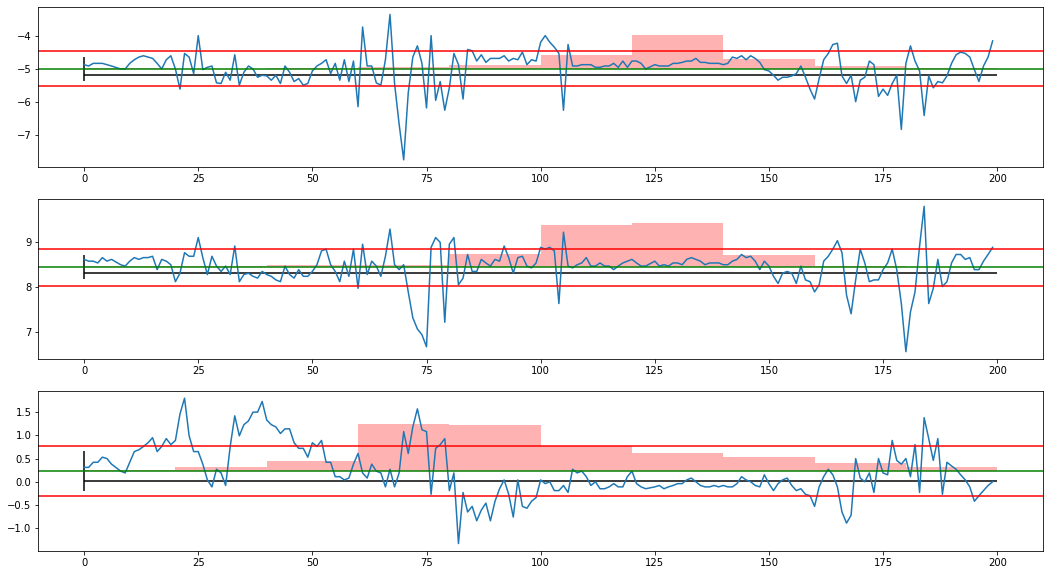

In [ ]:
tsr = TSRepresentation(
    final_examples[50], 
    ["x-accel", "y-accel", "z-accel"], 
    ["user", "activity", "sample_index", "example_index"],
    "activity", 10)
tsr.representation = examples_representation_50
tsr.display_tsr((13, "Standing", 0.0, 0), ["x-accel", "y-accel", "z-accel"])

In [ ]:
examples_representation_50

x-accel-average  \
user activity   sample_index example_index                    
1    Downstairs 0.0          0                    -4.491725   
                             1                    -8.799900   
                             2                    -9.005400   
                1.0          0                    -2.942150   
                             1                    -6.842550   
...                                                     ...   
36   Walking    0.0          25                   -0.978950   
                             26                   -0.924100   
                             27                   -0.854825   
                             28                   -0.894100   
                             29                   -0.802675   

                                            x-accel-standard_deviation  \
user activity   sample_index example_index                               
1    Downstairs 0.0          0                                5.086188   
                             1                                5.126029   
                             2                                4.932544   
                1.0          0                                5.867922   
                             1                                5.920913   
...                                                                ...   
36   Walking    0.0          25                               2.468264   
                             26                               2.443494   
                             27                               2.282914   
                             28                               2.225908   
                             29                               2.120516   

                                            x-accel-avg_absolute_difference  \
user activity   sample_index example_index                                    
1    Downstairs 0.0          0                                     3.992694   
                             1                                     4.086898   
                             2                                     3.801660   
                1.0          0                                     4.697492   
                             1                                     4.579320   
...                                                                     ...   
36   Walking    0.0          25                                    1.899671   
                             26                                    1.862682   
                             27                                    1.753141   
                             28                                    1.658808   
                             29                                    1.614321   

                                            x-accel-time_between_peaks  \
user activity   sample_index example_index                               
1    Downstairs 0.0          0                              200.000000   
                             1                                6.250000   
                             2                                6.250000   
                1.0          0                              200.000000   
                             1                                6.896552   
...                                                                ...   
36   Walking    0.0          25                              25.000000   
                             26                              11.764706   
                             27                              11.764706   
                             28                              11.764706   
                             29                              12.500000   

                                            y-accel-average  \
user activity   sample_index example_index                    
1    Downstairs 0.0          0                     8.869500   
                             1                     5.703800   
                  

Les cellules suivantes ont pour objectif d'effectuer une rapide étude de la dispersion des données après changelent de représentation (ACP sur les variables résumées en gardant les 3 composantes principales)

In [ ]:
def compute_tsr_pca(tsr):
    """
      Computes a PCA on the change of representation.
      Returns the projected vectors for each example, as well
      as the projected centers for each class
    """
    representation = tsr.get_representation()
    attributes = list(representation.columns)
    attributes.remove("class")

    tsr_pca = PCA(n_components=3)
    tsr_pca.fit(representation[attributes])

    projected_tsr = pd.DataFrame(tsr_pca.transform(representation[attributes]))
    projected_tsr.index = representation.index.copy()
    projected_tsr["class"] = representation["class"]

    class_centers = representation.groupby(["class"]).mean()
    projected_centers = pd.DataFrame(tsr_pca.transform(class_centers))
    projected_centers.index = class_centers.index.copy()

    return tsr_pca, projected_tsr, projected_centers

In [ ]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


In [ ]:
def display_tsr_pca(projected_tsr, projected_means):
    """
      Displays the change of representation PCA
    """
    categories = np.unique(projected_tsr["class"])
    colors = [(rd.random(), rd.random(), rd.random(), 1) for i in range(len(categories))]
    colordict = dict(zip(categories, colors))

    tsr_colors = projected_tsr["class"].apply(lambda x: colordict[x])
    class_colors = list(map(lambda x: colordict[x], list(projected_means.index)))

    fig = plt.figure(figsize=(18,10))
    ax = plt.axes(projection='3d')

    ax.scatter3D(test[0], test[1], test[1], c=tsr_colors, s=6, alpha=0.5, zorder=2)
    ax.scatter3D(projected_means[0], projected_means[1], projected_means[2], c=class_colors, s=100, edgecolors='black', alpha=1, zorder=1)

    for index in projected_means.index:
        ax.text(
            projected_means.loc[index, 0] + 30 * rd.random(), 
            projected_means.loc[index, 1] + 30 * rd.random(), 
            projected_means.loc[index, 2] + 30 * rd.random(),
            '%s' % index, size=20, zorder=1, color=colordict[index]
        )


    set_axes_equal(ax)

NameError: ignored

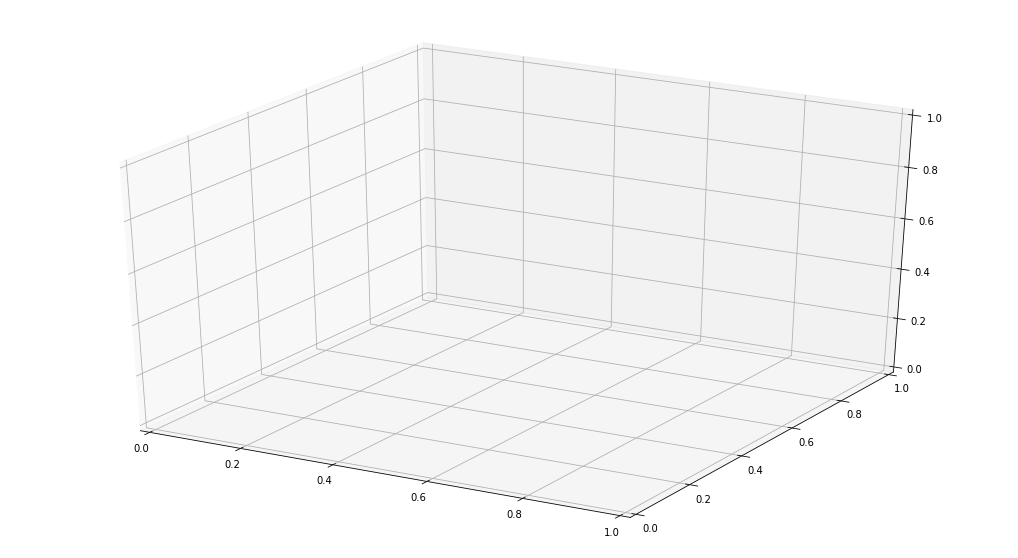

In [ ]:
tsr_pca, projected_tsr, projected_centers = compute_tsr_pca(tsr)
display_tsr_pca(projected_tsr, projected_centers)

In [ ]:
projected_centers

### **Etude par distances**

Cette partie d'intéresse à la dispersion des données via les mesures de distance L2 et DTW

In [ ]:
# Définition L2

In [ ]:
# Importation DTW
import numpy as np
import torch
from numba import jit
from torch.autograd import Function

@jit(nopython = True)
def compute_softdtw(D, gamma):
  B = D.shape[0]
  N = D.shape[1]
  M = D.shape[2]
  R = np.ones((B, N + 2, M + 2)) * np.inf
  R[:, 0, 0] = 0
  for k in range(B):
    for j in range(1, M + 1):
      for i in range(1, N + 1):
        r0 = -R[k, i - 1, j - 1] / gamma
        r1 = -R[k, i - 1, j] / gamma
        r2 = -R[k, i, j - 1] / gamma
        rmax = max(max(r0, r1), r2)
        rsum = np.exp(r0 - rmax) + np.exp(r1 - rmax) + np.exp(r2 - rmax)
        softmin = - gamma * (np.log(rsum) + rmax)
        R[k, i, j] = D[k, i - 1, j - 1] + softmin
  return R

@jit(nopython = True)
def compute_softdtw_backward(D_, R, gamma):
  B = D_.shape[0]
  N = D_.shape[1]
  M = D_.shape[2]
  D = np.zeros((B, N + 2, M + 2))
  E = np.zeros((B, N + 2, M + 2))
  D[:, 1:N + 1, 1:M + 1] = D_
  E[:, -1, -1] = 1
  R[:, : , -1] = -np.inf
  R[:, -1, :] = -np.inf
  R[:, -1, -1] = R[:, -2, -2]
  for k in range(B):
    for j in range(M, 0, -1):
      for i in range(N, 0, -1):
        a0 = (R[k, i + 1, j] - R[k, i, j] - D[k, i + 1, j]) / gamma
        b0 = (R[k, i, j + 1] - R[k, i, j] - D[k, i, j + 1]) / gamma
        c0 = (R[k, i + 1, j + 1] - R[k, i, j] - D[k, i + 1, j + 1]) / gamma
        a = np.exp(a0)
        b = np.exp(b0)
        c = np.exp(c0)
        E[k, i, j] = E[k, i + 1, j] * a + E[k, i, j + 1] * b + E[k, i + 1, j + 1] * c
  return E[:, 1:N + 1, 1:M + 1]

class _SoftDTW(Function):
  @staticmethod
  def forward(ctx, D, gamma):
    dev = D.device
    dtype = D.dtype
    gamma = torch.Tensor([gamma]).to(dev).type(dtype) # dtype fixed
    D_ = D.detach().cpu().numpy()
    g_ = gamma.item()
    R = torch.Tensor(compute_softdtw(D_, g_)).to(dev).type(dtype)
    ctx.save_for_backward(D, R, gamma)
    return R[:, -2, -2]

  @staticmethod
  def backward(ctx, grad_output):
    dev = grad_output.device
    dtype = grad_output.dtype
    D, R, gamma = ctx.saved_tensors
    D_ = D.detach().cpu().numpy()
    R_ = R.detach().cpu().numpy()
    g_ = gamma.item()
    E = torch.Tensor(compute_softdtw_backward(D_, R_, g_)).to(dev).type(dtype)
    return grad_output.view(-1, 1, 1).expand_as(E) * E, None

class SoftDTW(torch.nn.Module):
  def __init__(self, gamma=1.0, normalize=False):
    super(SoftDTW, self).__init__()
    self.normalize = normalize
    self.gamma=gamma
    self.func_dtw = _SoftDTW.apply

  def calc_distance_matrix(self, x, y):
    n = x.size(1)
    m = y.size(1)
    d = x.size(2)
    x = x.unsqueeze(2).expand(-1, n, m, d)
    y = y.unsqueeze(1).expand(-1, n, m, d)
    dist = torch.pow(x - y, 2).sum(3)
    return dist

  def forward(self, x, y):
    assert len(x.shape) == len(y.shape)
    squeeze = False
    if len(x.shape) < 3:
      x = x.unsqueeze(0)
      y = y.unsqueeze(0)
      squeeze = True
    if self.normalize:
      D_xy = self.calc_distance_matrix(x, y)
      out_xy = self.func_dtw(D_xy, self.gamma)
      D_xx = self.calc_distance_matrix(x, x)
      out_xx = self.func_dtw(D_xx, self.gamma)
      D_yy = self.calc_distance_matrix(y, y)
      out_yy = self.func_dtw(D_yy, self.gamma)
      result = out_xy - 1/2 * (out_xx + out_yy) # distance
    else:
      D_xy = self.calc_distance_matrix(x, y)
      out_xy = self.func_dtw(D_xy, self.gamma)
      result = out_xy # discrepancy
    return result.squeeze(0) if squeeze else result

In [ ]:
def apply_dtw(dtw, df1, df2, cols):
    tensor1 = torch.tensor([df1[cols].values])
    tensor2 = torch.tensor([df2[cols].values])
    return dtw(tensor1, tensor2)

In [ ]:
example1 = sub_df(example_cleaned_data, 1, "Jogging", 1.0)
example1 = example1[example1["example_index"] == 1]
example1 = example1.head(10)[["x-accel", "y-accel", "z-accel"]]

example2 = sub_df(example_cleaned_data, 1, "Jogging", 1.0)
example2 = example2[example2["example_index"] == 2]
example2 = example2.head(10)[["x-accel", "y-accel", "z-accel"]]

dtw = SoftDTW(normalize=True)

apply_dtw(dtw, example1, example2, ["x-accel", "y-accel", "z-accel"])

Les cellules suivantes présentent une visualisation des données dans un espace projeté par **t-SNE** (espace de dimension 2 conservant les propriétés de similarité entre exemples)

In [ ]:
# t-SNE
from sklearn import manifold

def my_metric(x, y):
    if x[0] == y[0]:
        return 0
    if x[0] == "a" and y[0] == "b":
        return 1
    return 2
    pass

tsne = manifold.TSNE(metric=my_metric)
test_array = [ ["a"], ["b"], ["c"] ]
tsne.fit_transform(test_array)

## **Utilisation de classifieurs**  

//TODO

### Rocket

In [ ]:
!pip install sktime
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.rocket import Rocket

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 72.5 MB/s eta 0:00:00


In [ ]:
select_att = [c for c in flattened_final_examples[50] if 'att' in c]
X = pd.DataFrame(flattened_final_examples[50])
count_activity_size = flattened_final_examples[50].groupby('activity').size()
count_activity_size


NameError: ignored

In [ ]:
select_att = [c for c in flattened_final_examples[40] if 'att' in c]
X40 = pd.DataFrame(flattened_final_examples[40])
count_activity_size = flattened_final_examples[40].groupby('activity').size()
count_activity_size

activity
Downstairs    107
Jogging       419
Sitting        75
Standing       86
Upstairs      134
Walking       482
dtype: int64

In [ ]:
import pandas as pd

In [ ]:
Y=pd.DataFrame(columns=['activity'])
def assign_activities(df):
  for i in range(334) :
    df.at[i,'activity'] = 'Downstairs'
  for i in range(334,1557) :
    df.at[i,'activity'] = 'Jogging'
  for i in range(1557,1767) :
    df.at[i,'activity'] = 'Sitting'
  for i in range(1767,1909) :
    df.at[i,'activity'] = 'Standing'
  for i in range(1909,2327) :
    df.at[i,'activity'] = 'Upstairs'
  for i in range(2327,3900) :
    df.at[i,'activity'] = 'Walking'
assign_activities(Y)

In [ ]:
Y40=pd.DataFrame(columns=['activity'])
def assign_activities(df):
  for i in range(107) :
    df.at[i,'activity'] = 'Downstairs'
  for i in range(107,526) :
    df.at[i,'activity'] = 'Jogging'
  for i in range(526,601) :
    df.at[i,'activity'] = 'Sitting'
  for i in range(601,687) :
    df.at[i,'activity'] = 'Standing'
  for i in range(687,821) :
    df.at[i,'activity'] = 'Upstairs'
  for i in range(821,1303) :
    df.at[i,'activity'] = 'Walking'
assign_activities(Y40)

In [ ]:
import os
from sktime.datasets import load_from_arff_to_dataframe
X,y = load_from_arff_to_dataframe(
    "/content/WISDM_ar_v1.1_final_examples_50ms.arff")
len(X)

FileNotFoundError: ignored

In [ ]:
X40,y40 = load_from_arff_to_dataframe(
    "/content/WISDM_ar_v1.1_final_examples_40ms.arff")
len(X40)

FileNotFoundError: ignored

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [ ]:
X40_train, X40_test, y40_train, y40_test = train_test_split(X40, Y40, test_size=0.2, random_state=0)

NameError: ignored

In [ ]:
import time
import numpy as np

In [ ]:
start_time=time.time()
rocket = Rocket()
rocket.fit(X_train)
X_train_transform = rocket.transform(X_train)
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
classifier.fit(X_train_transform, y_train['activity'])
end_time=time.time()
execution_time=end_time-start_time
execution_time


In [ ]:
X_test_transform = rocket.transform(X_test)
classifier.score(X_test_transform, y_test)


In [ ]:
X40_transform= rocket.transform(X40)
classifier.score(X40_transform,Y40)

0.3461243284727552

In [ ]:
rocket.fit(X40_train)
X40_train_transform = rocket.transform(X40_train)
classifier40 = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
classifier40.fit(X40_train_transform, y40_train['activity'])

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                  normalize=True)

In [ ]:
X40_test_transform = rocket.transform(X40_test)
classifier40.score(X40_test_transform, y40_test)

0.9003831417624522

Cross-validation

In [ ]:

from sklearn.model_selection import cross_validate 
rocket.fit(X)
X_transform=rocket.transform(X)
scores = cross_validate(classifier, X_transform, y, cv=5)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(

In [ ]:
scores

{'fit_time': array([22.81842995, 19.95973229, 20.05240798, 20.18431473, 19.86509776]),
 'score_time': array([0.39980197, 0.39882445, 0.39689898, 0.3984859 , 0.39711046]),
 'test_score': array([0.86794872, 0.96794872, 0.96794872, 0.89230769, 0.91923077])}

### miniRocket

In [ ]:
from sktime.transformations.panel.rocket import MiniRocketMultivariate
start_time=time.time()
MiniRocketMultivariate = MiniRocketMultivariate() 
MiniRocketMultivariate.fit(X_train)
X_train_transform_miniR = MiniRocketMultivariate.transform(X_train)
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
classifier.fit(X_train_transform_miniR, y_train)
end_time=time.time()
execution_time=end_time-start_time
X_test_transform_miniR= MiniRocketMultivariate.transform(X_test)
classifier.score(X_test_transform_miniR, y_test)




/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:1182: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9692307692307692

In [ ]:
execution_time

126.5749933719635

In [ ]:
!pip install joblib
import joblib
joblib.dump(classifier, 'MiniRocketClf.pkl')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


['MiniRocketClf.pkl']

In [ ]:
X40_transform_miniR=MiniRocketMultivariate.transform(X40)
classifier.score(X40_transform_miniR,Y40)

0.2778204144282425

In [ ]:
MiniRocketMultivariate.fit(X40_train)
X40_train_transform_miniR = MiniRocketMultivariate.transform(X40_train)
classifier40_miniR = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
classifier40_miniR.fit(X40_train_transform_miniR, y40_train)
X40_test_transform_miniR= MiniRocketMultivariate.transform(X40_test)
classifier40_miniR.score(X40_test_transform_miniR, y40_test)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:1059: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


0.9348659003831418

###Time Series Forest/Learning Shapelets

The Time Series Forest classification or the Learning Shapelets method can not be applied in our case, because the fit method of TSF takes a univariate time series as parameter, and ours are multivariate time series.

### HIVE-COTE2.0


In [ ]:
final_examples[50].columns

Index(['user', 'activity', 'timestamp', 'x-accel', 'y-accel', 'z-accel',
       'sample_index', 'snap_index', 'true_period', 'time_span',
       'example_index'],
      dtype='object')

In [ ]:
from sktime.classification.hybrid import HIVECOTEV2
hv2 = HIVECOTEV2()

In [ ]:
hv2.fit(X_train, y_train['activity'])



KeyboardInterrupt: ignored

In [ ]:
from sktime.classification.distance_based import ProximityForest

In [ ]:
proximityF = ProximityForest(n_estimators=2, max_depth=2, n_stump_evaluations=1)
proximityF.fit(X_train, y_train['activity'])

In [ ]:
newY=pd.Series(y_train)

ValueError: ignored

### ShapeletTransformClassifier

In [ ]:
from sktime.classification.shapelet_based import ShapeletTransformClassifier
from sktime.classification.sklearn import RotationForest
start_time=time.time()
clfSTC = ShapeletTransformClassifier(
    estimator=RotationForest(n_estimators=10),
    n_shapelet_samples=100,
    max_shapelets=10,
    batch_size=20,
)
clfSTC.fit(X_train, y_train['activity'])
end_time=time.time()
execution_time=end_time-start_time
execution_time


144.01255440711975

In [ ]:
clfSTC.score(X_test,y_test['activity'])

0.7461538461538462

In [ ]:
clfSTC.score(X40,Y40['activity'])

0.4128933231005372

In [ ]:
clfSTC40 = ShapeletTransformClassifier(
    estimator=RotationForest(n_estimators=10),
    n_shapelet_samples=100,
    max_shapelets=10,
    batch_size=20,
)
clfSTC40.fit(X40_train, y40_train['activity'])
clfSTC40.score(X40_test,y40_test['activity'])


0.7203065134099617

###CBOSS

In [ ]:
from sktime.classification.dictionary_based import ContractableBOSS
start_time=time.time()
clfCBOSS = ContractableBOSS(n_parameter_samples=10, max_ensemble_size=3)
clfCBOSS.fit(X_train, y_train['activity'])
end_time=time.time()
execution_time=end_time-start_time
execution_time

126.80384135246277

In [ ]:
clfCBOSS.score(X_test, y_test['activity'])

0.8846153846153846

In [ ]:
clfCBOSS.score(X40,Y40)

0.31005372217958554

In [ ]:
clfCBOSS.fit(X40_train, y40_train['activity'])
clfCBOSS.score(X40_test, y40_test['activity'])

0.9272030651340997

## **Utilisation d'algorithmes de clustering**  

//TODO